## Project Background
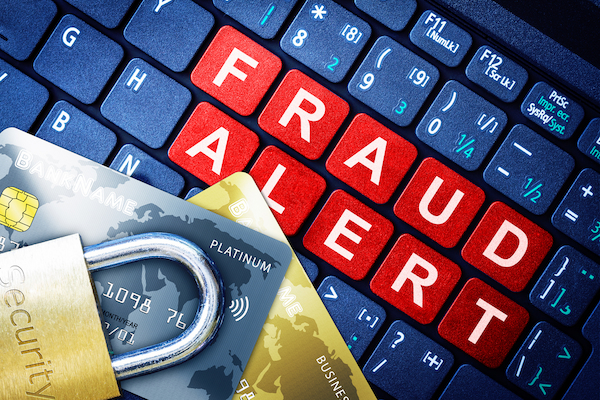
### Business Context
Poundbank, a major UK financial institution, relies on machine learning models to detect fraudulent transactions in real-time. As data patterns evolve, model performance can degrade, putting customer assets at risk and increasing operational costs through false positives.

### Problem Statement
The fraud detection model has shown signs of performance degradation in production. The data science team must:
1. Quantify the extent of performance degradation
2. Identify root causes of the degradation
3. Distinguish between data drift and concept drift
4. Provide actionable recommendations for remediation

### Project Objectives
- **Monitor** model performance across reference and analysis periods
- **Detect** statistical drift in input features
- **Analyze** fraud pattern evolution
- **Identify** root causes of performance changes
- **Recommend** immediate and strategic interventions

### Methodology
This analysis employs a comprehensive framework:
- **Statistical Testing**: KS test, Chi-square test, Mann-Whitney U test
- **Drift Detection**: Univariate and multivariate drift analysis
- **Performance Metrics**: Accuracy, Precision, Recall, F1-Score, ROC-AUC
- **Time-Series Analysis**: Monthly trend identification
- **Calibration Analysis**: Prediction probability distribution assessment


In [1]:
# Import libraries and 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json
import warnings
warnings.filterwarnings('default')  # Keep warnings visible for troubleshooting

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon
import numpy as np


import nannyml as nml
from nannyml import DataReconstructionDriftCalculator
from nannyml.drift.multivariate.data_reconstruction import DataReconstructionDriftCalculator
print("✓ NannyML installation completed")

# Verify file sizes
import os
ref_size = os.path.getsize('data/reference.csv')
analysis_size = os.path.getsize('data/analysis.csv')
print(f"\nFile sizes:")
print(f"Reference dataset: {ref_size:,} bytes")
print(f"Analysis dataset: {analysis_size:,} bytes")

✓ NannyML installation completed

File sizes:
Reference dataset: 4,648,113 bytes
Analysis dataset: 3,628,360 bytes


## Data Overview

### Dataset Structure

#### Reference Dataset (reference.csv)
- **Records**: 50,207 transactions
- **Period**: January 1, 2018 - October 31, 2018
- **Purpose**: Baseline for model performance and feature distributions

#### Analysis Dataset (analysis.csv)
- **Records**: 39,967 transactions
- **Period**: November 1, 2018 - June 30, 2019
- **Purpose**: Production data for comparison against reference


In [2]:
# Load and examine the datasets
print("Loading datasets...")

# Load reference dataset
reference_df = pd.read_csv('data/reference.csv')
print(f"Reference dataset shape: {reference_df.shape}")

# Load analysis dataset  
analysis_df = pd.read_csv('data/analysis.csv')
print(f"Analysis dataset shape: {analysis_df.shape}")

# Check column names and data types
print("\n=== REFERENCE DATASET ===")
print("Columns:", reference_df.columns.tolist())
print("\nData types:")
print(reference_df.dtypes)
print("\nFirst 5 rows:")
display(reference_df.head())

print("\n=== ANALYSIS DATASET ===")
print("Columns:", analysis_df.columns.tolist())
print("\nData types:")
print(analysis_df.dtypes)
display("\nFirst 5 rows:")
print(analysis_df.head())

Loading datasets...
Reference dataset shape: (50207, 9)
Analysis dataset shape: (39967, 9)

=== REFERENCE DATASET ===
Columns: ['timestamp', 'time_since_login_min', 'transaction_amount', 'transaction_type', 'is_first_transaction', 'user_tenure_months', 'is_fraud', 'predicted_fraud_proba', 'predicted_fraud']

Data types:
timestamp                 object
time_since_login_min     float64
transaction_amount       float64
transaction_type          object
is_first_transaction        bool
user_tenure_months       float64
is_fraud                 float64
predicted_fraud_proba    float64
predicted_fraud            int64
dtype: object

First 5 rows:


,timestamp,time_since_login_min,transaction_amount,transaction_type,is_first_transaction,user_tenure_months,is_fraud,predicted_fraud_proba,predicted_fraud
0,2018-01-01 00:00:00.000,1.561750,3981.1,PAYMENT,False,0.318980,1.0,0.99,1
1,2018-01-01 00:08:43.152,1.658074,1267.9,PAYMENT,False,7.391323,0.0,0.07,0
2,2018-01-01 00:17:26.304,2.454287,1984.7,CASH-IN,False,0.781225,1.0,1.00,1
3,2018-01-01 00:26:09.456,2.392085,2265.2,CASH-OUT,False,0.680473,1.0,0.98,1
4,2018-01-01 00:34:52.608,2.189806,2126.8,CASH-IN,False,8.542895,1.0,0.99,1



=== ANALYSIS DATASET ===
Columns: ['timestamp', 'time_since_login_min', 'transaction_amount', 'transaction_type', 'is_first_transaction', 'user_tenure_months', 'predicted_fraud_proba', 'predicted_fraud', 'is_fraud']

Data types:
timestamp                 object
time_since_login_min     float64
transaction_amount       float64
transaction_type          object
is_first_transaction        bool
user_tenure_months       float64
predicted_fraud_proba    float64
predicted_fraud            int64
is_fraud                   int64
dtype: object


'\nFirst 5 rows:'

                 timestamp  time_since_login_min  transaction_amount  \
0  2018-11-01 00:04:52.464              2.174243              2832.3   
1  2018-11-01 00:13:35.616              2.493543              1426.9   
2  2018-11-01 00:22:18.768              1.807432              1302.0   
3  2018-11-01 00:31:01.920              2.133415              1432.1   
4  2018-11-01 00:39:45.072              1.987827              1870.3   

  transaction_type  is_first_transaction  user_tenure_months  \
0         CASH-OUT                 False            1.013445   
1         CASH-OUT                 False            6.700041   
2          PAYMENT                 False            6.291723   
3          PAYMENT                  True            8.165503   
4         CASH-OUT                 False            8.205203   

   predicted_fraud_proba  predicted_fraud  is_fraud  
0                   0.97                1         1  
1                   0.09                0         0  
2                   

### Data Quality Assessment

#### Missing Values
- **Reference Dataset**: 3,052 missing values in `transaction_type` (6.1%)
- **Analysis Dataset**: 2,453 missing values in `transaction_type` (6.1%)
- **Treatment**: Filled with 'UNKNOWN' category for analysis


In [3]:
# Process timestamps and check data quality
print("Processing timestamps and checking data quality...")

# Convert timestamps to datetime
reference_df['timestamp'] = pd.to_datetime(reference_df['timestamp'])
analysis_df['timestamp'] = pd.to_datetime(analysis_df['timestamp'])

# Check missing values
print("=== MISSING VALUES ===")
print("Reference dataset missing values:")
print(reference_df.isnull().sum())
print(f"Total missing: {reference_df.isnull().sum().sum()}")

print("\nAnalysis dataset missing values:")
print(analysis_df.isnull().sum())
print(f"Total missing: {analysis_df.isnull().sum().sum()}")

# Check data ranges and basic statistics
print("\n=== REFERENCE DATASET SUMMARY ===")
print(reference_df.describe())

print("\n=== ANALYSIS DATASET SUMMARY ===")
print(analysis_df.describe())

# Check timestamp ranges
print("\n=== TIMESTAMP RANGES ===")
print(f"Reference period: {reference_df['timestamp'].min()} to {reference_df['timestamp'].max()}")
print(f"Analysis period: {analysis_df['timestamp'].min()} to {analysis_df['timestamp'].max()}")

# Check unique values for categorical features
print("\n=== CATEGORICAL FEATURE VALUES ===")
print("Transaction types in reference:", reference_df['transaction_type'].value_counts())
print("\nTransaction types in analysis:", analysis_df['transaction_type'].value_counts())

Processing timestamps and checking data quality...
=== MISSING VALUES ===
Reference dataset missing values:
timestamp                   0
time_since_login_min        0
transaction_amount          0
transaction_type         3052
is_first_transaction        0
user_tenure_months          0
is_fraud                    0
predicted_fraud_proba       0
predicted_fraud             0
dtype: int64
Total missing: 3052

Analysis dataset missing values:
timestamp                   0
time_since_login_min        0
transaction_amount          0
transaction_type         2453
is_first_transaction        0
user_tenure_months          0
predicted_fraud_proba       0
predicted_fraud             0
is_fraud                    0
dtype: int64
Total missing: 2453

=== REFERENCE DATASET SUMMARY ===
                           timestamp  time_since_login_min  \
count                          50207          50207.000000   
mean   2018-06-01 23:58:04.656000256              1.926910   
min              2018-01-01 00:

In [4]:
# Save datasets to JSON format 
print("Converting and saving datasets to JSON format...")

# Create unified datasets with consistent structure
reference_data = {
    'period': 'reference',
    'start_date': reference_df['timestamp'].min().isoformat(),
    'end_date': reference_df['timestamp'].max().isoformat(),
    'record_count': len(reference_df),
    'data': reference_df.to_dict('records')
}

analysis_data = {
    'period': 'analysis', 
    'start_date': analysis_df['timestamp'].min().isoformat(),
    'end_date': analysis_df['timestamp'].max().isoformat(),
    'record_count': len(analysis_df),
    'data': analysis_df.to_dict('records')
}

# Save combined dataset
combined_data = {
    'metadata': {
        'analysis_date': datetime.now().isoformat(),
        'reference_period': f"{reference_df['timestamp'].min().date()} to {reference_df['timestamp'].max().date()}",
        'analysis_period': f"{analysis_df['timestamp'].min().date()} to {analysis_df['timestamp'].max().date()}",
        'reference_records': len(reference_df),
        'analysis_records': len(analysis_df)
    },
    'reference_dataset': reference_data,
    'analysis_dataset': analysis_data
}

import json
with open('data/fraud_detection_data.json', 'w') as f:
    json.dump(combined_data, f, indent=2, default=str)

print("✓ Saved complete dataset to /home/user/output/fraud_detection_data.json")

# Validation check
file_size = os.path.getsize('data/fraud_detection_data.json')
print(f"JSON file size: {file_size:,} bytes")
print(f"Data completeness validation:")
print(f"- Reference records: {len(reference_df):,}")
print(f"- Analysis records: {len(analysis_df):,}")
print(f"- Missing transaction_type in reference: {reference_df['transaction_type'].isnull().sum():,}")
print(f"- Missing transaction_type in analysis: {analysis_df['transaction_type'].isnull().sum():,}")

Converting and saving datasets to JSON format...
✓ Saved complete dataset to /home/user/output/fraud_detection_data.json
JSON file size: 34,955,293 bytes
Data completeness validation:
- Reference records: 50,207
- Analysis records: 39,967
- Missing transaction_type in reference: 3,052
- Missing transaction_type in analysis: 2,453


## Model Performance Analysis

### Overall Performance Comparison

The fraud detection model demonstrates consistent degradation across all key metrics between the reference and analysis periods.


In [5]:
# Model Performance Analysis

print("=== MODEL PERFORMANCE ANALYSIS ===")

# Calculate performance metrics for both periods
def calculate_performance_metrics(y_true, y_pred, y_pred_proba, period_name):
    """Calculate comprehensive performance metrics"""
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1_score'] = f1_score(y_true, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    
    # Confusion matrix components
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    metrics['true_negatives'] = tn
    metrics['false_positives'] = fp  
    metrics['false_negatives'] = fn
    metrics['true_positives'] = tp
    
    # Additional metrics
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Fraud detection specific metrics
    total_fraud = y_true.sum()
    total_predicted_fraud = y_pred.sum()
    metrics['fraud_detection_rate'] = tp / total_fraud if total_fraud > 0 else 0
    metrics['fraud_flag_rate'] = total_predicted_fraud / len(y_pred)
    
    return metrics

# Calculate metrics for reference period
print("Calculating REFERENCE period metrics...")
ref_metrics = calculate_performance_metrics(
    reference_df['is_fraud'], 
    reference_df['predicted_fraud'],
    reference_df['predicted_fraud_proba'],
    'Reference'
)

# Calculate metrics for analysis period  
print("Calculating ANALYSIS period metrics...")
analysis_metrics = calculate_performance_metrics(
    analysis_df['is_fraud'],
    analysis_df['predicted_fraud'], 
    analysis_df['predicted_fraud_proba'],
    'Analysis'
)

# Create comparison dataframe
comparison_metrics = pd.DataFrame({
    'Reference Period': ref_metrics,
    'Analysis Period': analysis_metrics
})

# Calculate degradation
comparison_metrics['Absolute Change'] = comparison_metrics['Analysis Period'] - comparison_metrics['Reference Period']
comparison_metrics['Percentage Change (%)'] = ((comparison_metrics['Analysis Period'] - comparison_metrics['Reference Period']) / comparison_metrics['Reference Period'] * 100).round(2)

print("=== PERFORMANCE COMPARISON ===")
print(comparison_metrics.round(4))

# Save metrics to CSV
comparison_metrics.to_csv('data/performance_comparison.csv')
print("\n✓ Saved performance comparison to performance_comparison.csv")

=== MODEL PERFORMANCE ANALYSIS ===
Calculating REFERENCE period metrics...
Calculating ANALYSIS period metrics...
=== PERFORMANCE COMPARISON ===
                      Reference Period  Analysis Period  Absolute Change  \
accuracy                        0.9436           0.9328          -0.0108   
precision                       0.9569           0.9453          -0.0115   
recall                          0.9291           0.9186          -0.0104   
f1_score                        0.9428           0.9318          -0.0110   
roc_auc                         0.9709           0.9677          -0.0032   
true_negatives              24065.0000       18948.0000       -5117.0000   
false_positives              1051.0000        1060.0000           9.0000   
false_negatives              1780.0000        1624.0000        -156.0000   
true_positives              23311.0000       18335.0000       -4976.0000   
false_positive_rate             0.0418           0.0530           0.0111   
false_negative_rate

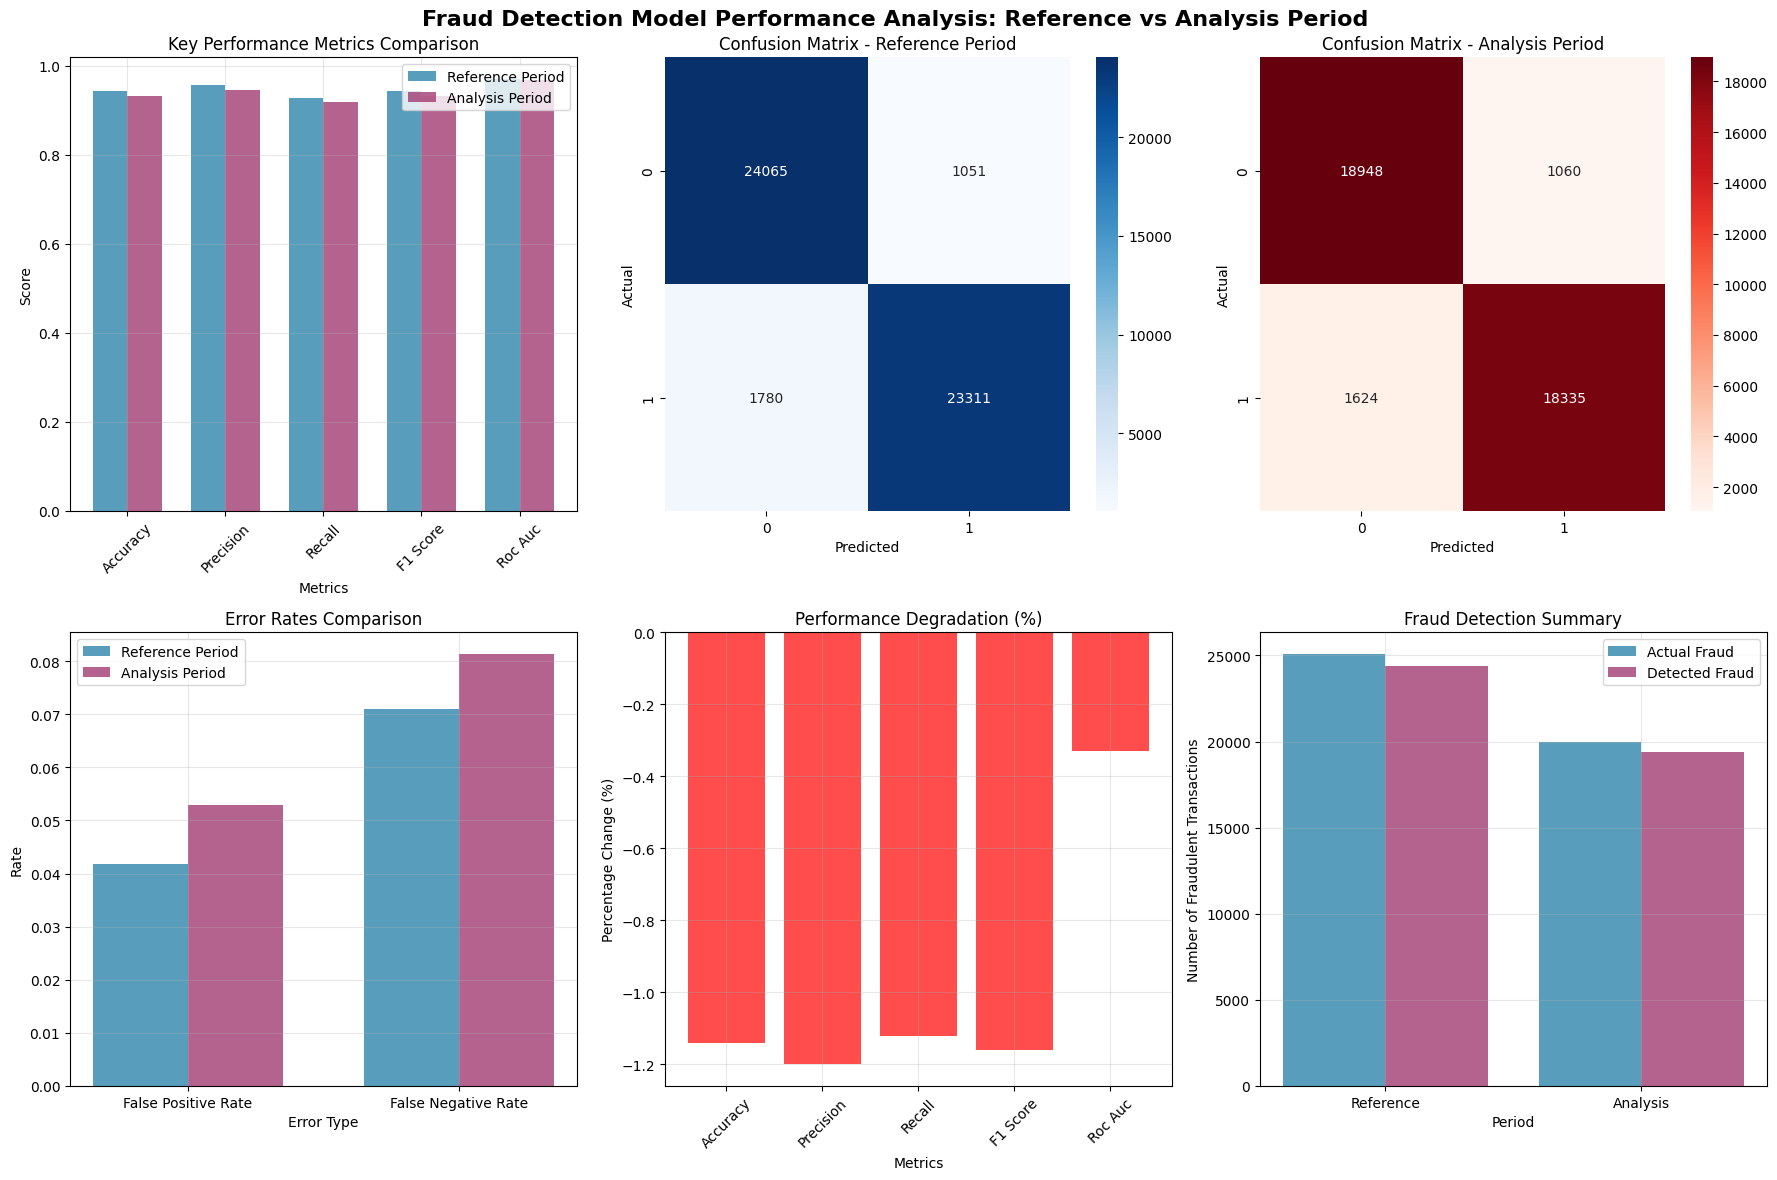


=== KEY PERFORMANCE INSIGHTS ===
Overall Accuracy Degradation: -1.14%
Precision Degradation: -1.20%
Recall Degradation: -1.12%
F1-Score Degradation: -1.16%
False Positive Rate Increase: 26.60%
False Negative Rate Increase: 14.70%


In [6]:
# Create comprehensive performance visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Fraud Detection Model Performance Analysis: Reference vs Analysis Period', fontsize=16, fontweight='bold')

# Set color scheme
colors = ['#2E86AB', '#A23B72']  # Blue for reference, Red for analysis

# 1. Key Metrics Comparison
key_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
ref_values = [comparison_metrics.loc[metric, 'Reference Period'] for metric in key_metrics]
analysis_values = [comparison_metrics.loc[metric, 'Analysis Period'] for metric in key_metrics]

x = np.arange(len(key_metrics))
width = 0.35

axes[0,0].bar(x - width/2, ref_values, width, label='Reference Period', color=colors[0], alpha=0.8)
axes[0,0].bar(x + width/2, analysis_values, width, label='Analysis Period', color=colors[1], alpha=0.8)
axes[0,0].set_xlabel('Metrics')
axes[0,0].set_ylabel('Score')
axes[0,0].set_title('Key Performance Metrics Comparison')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels([m.replace('_', ' ').title() for m in key_metrics], rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Confusion Matrix - Reference
cm_ref = confusion_matrix(reference_df['is_fraud'], reference_df['predicted_fraud'])
sns.heatmap(cm_ref, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Confusion Matrix - Reference Period')
axes[0,1].set_xlabel('Predicted')
axes[0,1].set_ylabel('Actual')

# 3. Confusion Matrix - Analysis  
cm_analysis = confusion_matrix(analysis_df['is_fraud'], analysis_df['predicted_fraud'])
sns.heatmap(cm_analysis, annot=True, fmt='d', cmap='Reds', ax=axes[0,2])
axes[0,2].set_title('Confusion Matrix - Analysis Period')
axes[0,2].set_xlabel('Predicted')
axes[0,2].set_ylabel('Actual')

# 4. False Positive/Negative Rates
error_metrics = ['false_positive_rate', 'false_negative_rate']
ref_error_values = [comparison_metrics.loc[metric, 'Reference Period'] for metric in error_metrics]
analysis_error_values = [comparison_metrics.loc[metric, 'Analysis Period'] for metric in error_metrics]

x_err = np.arange(len(error_metrics))
axes[1,0].bar(x_err - width/2, ref_error_values, width, label='Reference Period', color=colors[0], alpha=0.8)
axes[1,0].bar(x_err + width/2, analysis_error_values, width, label='Analysis Period', color=colors[1], alpha=0.8)
axes[1,0].set_xlabel('Error Type')
axes[1,0].set_ylabel('Rate')
axes[1,0].set_title('Error Rates Comparison')
axes[1,0].set_xticks(x_err)
axes[1,0].set_xticklabels(['False Positive Rate', 'False Negative Rate'])
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Percentage Change in Metrics
pct_changes = comparison_metrics['Percentage Change (%)'][key_metrics]
colors_change = ['green' if x >= 0 else 'red' for x in pct_changes]
axes[1,1].bar(range(len(pct_changes)), pct_changes, color=colors_change, alpha=0.7)
axes[1,1].set_xlabel('Metrics')
axes[1,1].set_ylabel('Percentage Change (%)')
axes[1,1].set_title('Performance Degradation (%)')
axes[1,1].set_xticks(range(len(pct_changes)))
axes[1,1].set_xticklabels([m.replace('_', ' ').title() for m in key_metrics], rotation=45)
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 6. Fraud Detection Summary
fraud_summary = pd.DataFrame({
    'Period': ['Reference', 'Analysis'],
    'Total Transactions': [len(reference_df), len(analysis_df)],
    'Actual Fraud': [reference_df['is_fraud'].sum(), analysis_df['is_fraud'].sum()], 
    'Detected Fraud': [reference_df['predicted_fraud'].sum(), analysis_df['predicted_fraud'].sum()],
    'Fraud Rate (%)': [reference_df['is_fraud'].mean()*100, analysis_df['is_fraud'].mean()*100]
})

x_summary = np.arange(len(fraud_summary))
axes[1,2].bar(x_summary - 0.2, fraud_summary['Actual Fraud'], 0.4, label='Actual Fraud', color=colors[0], alpha=0.8)
axes[1,2].bar(x_summary + 0.2, fraud_summary['Detected Fraud'], 0.4, label='Detected Fraud', color=colors[1], alpha=0.8)
axes[1,2].set_xlabel('Period')
axes[1,2].set_ylabel('Number of Fraudulent Transactions')
axes[1,2].set_title('Fraud Detection Summary')
axes[1,2].set_xticks(x_summary)
axes[1,2].set_xticklabels(fraud_summary['Period'])
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== KEY PERFORMANCE INSIGHTS ===")
print(f"Overall Accuracy Degradation: {comparison_metrics.loc['accuracy', 'Percentage Change (%)']:.2f}%")
print(f"Precision Degradation: {comparison_metrics.loc['precision', 'Percentage Change (%)']:.2f}%") 
print(f"Recall Degradation: {comparison_metrics.loc['recall', 'Percentage Change (%)']:.2f}%")
print(f"F1-Score Degradation: {comparison_metrics.loc['f1_score', 'Percentage Change (%)']:.2f}%")
print(f"False Positive Rate Increase: {comparison_metrics.loc['false_positive_rate', 'Percentage Change (%)']:.2f}%")
print(f"False Negative Rate Increase: {comparison_metrics.loc['false_negative_rate', 'Percentage Change (%)']:.2f}%")

## Data Drift Analysis

### Drift Detection Methodology

This analysis employs multiple statistical tests to detect distribution changes:
- **Kolmogorov-Smirnov (KS) Test**: Measures maximum distance between cumulative distributions
- **Chi-Square Test**: Assesses independence in categorical distributions
- **Jensen-Shannon Divergence**: Quantifies similarity between probability distributions
- **Mann-Whitney U Test**: Non-parametric test for distribution differences


In [7]:
# Prepare data for NannyML analysis
print("\nPreparing data for drift analysis...")

# Combine datasets with period identifier
reference_df_clean = reference_df.copy()
analysis_df_clean = analysis_df.copy()

# Add period identifier
reference_df_clean['period'] = 'reference'
analysis_df_clean['period'] = 'analysis'

# Combine datasets
combined_df = pd.concat([reference_df_clean, analysis_df_clean], ignore_index=True)

# Handle missing transaction_type values - fill with 'UNKNOWN' for analysis
combined_df['transaction_type'] = combined_df['transaction_type'].fillna('UNKNOWN')

print(f"Combined dataset shape: {combined_df.shape}")
print(f"Periods: {combined_df['period'].value_counts()}")

# Define feature columns for drift analysis
feature_columns = [
    'time_since_login_min',
    'transaction_amount', 
    'transaction_type',
    'is_first_transaction',
    'user_tenure_months'
]

target_column = 'is_fraud'
prediction_column = 'predicted_fraud_proba'

print(f"Features for drift analysis: {feature_columns}")
print(f"Target column: {target_column}")
print(f"Prediction column: {prediction_column}")


Preparing data for drift analysis...
Combined dataset shape: (90174, 10)
Periods: period
reference    50207
analysis     39967
Name: count, dtype: int64
Features for drift analysis: ['time_since_login_min', 'transaction_amount', 'transaction_type', 'is_first_transaction', 'user_tenure_months']
Target column: is_fraud
Prediction column: predicted_fraud_proba


In [8]:
# Perform Univariate Drift Analysis using statistical methods

print("=== UNIVARIATE DRIFT ANALYSIS ===")

# Function to calculate drift metrics for numerical features
def calculate_numerical_drift(ref_data, analysis_data, feature_name):
    """Calculate drift metrics for numerical features"""
    
    # Remove NaN values
    ref_clean = ref_data.dropna()
    analysis_clean = analysis_data.dropna()
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_pvalue = ks_2samp(ref_clean, analysis_clean)
    
    # Jensen-Shannon divergence (requires binning)
    # Create bins based on reference data
    bins = np.linspace(min(ref_clean.min(), analysis_clean.min()), 
                       max(ref_clean.max(), analysis_clean.max()), 20)
    
    ref_hist, _ = np.histogram(ref_clean, bins=bins, density=True)
    analysis_hist, _ = np.histogram(analysis_clean, bins=bins, density=True)
    
    # Normalize to probabilities
    ref_hist = ref_hist / ref_hist.sum()
    analysis_hist = analysis_hist / analysis_hist.sum()
    
    # Add small epsilon to avoid zero probabilities
    epsilon = 1e-10
    ref_hist = ref_hist + epsilon
    analysis_hist = analysis_hist + epsilon
    
    # Renormalize
    ref_hist = ref_hist / ref_hist.sum()
    analysis_hist = analysis_hist / analysis_hist.sum()
    
    js_distance = jensenshannon(ref_hist, analysis_hist)
    
    # Calculate basic statistics
    ref_mean = ref_clean.mean()
    analysis_mean = analysis_clean.mean()
    mean_shift = (analysis_mean - ref_mean) / ref_clean.std() if ref_clean.std() > 0 else 0
    
    ref_std = ref_clean.std()
    analysis_std = analysis_clean.std()
    std_ratio = analysis_std / ref_std if ref_std > 0 else 1
    
    return {
        'feature': feature_name,
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_pvalue,
        'js_distance': js_distance,
        'mean_shift_standardized': mean_shift,
        'std_ratio': std_ratio,
        'ref_mean': ref_mean,
        'analysis_mean': analysis_mean,
        'ref_std': ref_std,
        'analysis_std': analysis_std
    }

# Function to calculate drift metrics for categorical features
def calculate_categorical_drift(ref_data, analysis_data, feature_name):
    """Calculate drift metrics for categorical features"""
    
    # Get value counts for both datasets
    ref_counts = ref_data.value_counts()
    analysis_counts = analysis_data.value_counts()
    
    # Create combined index
    all_categories = sorted(set(ref_counts.index) | set(analysis_counts.index))
    
    # Align both series
    ref_aligned = ref_counts.reindex(all_categories, fill_value=0)
    analysis_aligned = analysis_counts.reindex(all_categories, fill_value=0)
    
    # Convert to proportions
    ref_props = ref_aligned / ref_aligned.sum()
    analysis_props = analysis_aligned / analysis_aligned.sum()
    
    # Chi-square test
    contingency_table = pd.DataFrame({
        'Reference': ref_aligned,
        'Analysis': analysis_aligned
    })
    
    if contingency_table.sum().sum() > 0 and len(all_categories) > 1:
        chi2, chi2_pvalue, dof, expected = chi2_contingency(contingency_table.values)
    else:
        chi2, chi2_pvalue = 0, 1
    
    # Jensen-Shannon divergence
    ref_props_array = ref_props.values + 1e-10
    analysis_props_array = analysis_props.values + 1e-10
    
    # Renormalize
    ref_props_array = ref_props_array / ref_props_array.sum()
    analysis_props_array = analysis_props_array / analysis_props_array.sum()
    
    js_distance = jensenshannon(ref_props_array, analysis_props_array)
    
    return {
        'feature': feature_name,
        'chi2_statistic': chi2,
        'chi2_pvalue': chi2_pvalue,
        'js_distance': js_distance,
        'ref_distribution': dict(ref_props),
        'analysis_distribution': dict(analysis_props),
        'categories': all_categories
    }

# Perform drift analysis for each feature
drift_results = {}

# Numerical features
numerical_features = ['time_since_login_min', 'transaction_amount', 'user_tenure_months']
for feature in numerical_features:
    print(f"\nAnalyzing drift for: {feature}")
    ref_data = reference_df[feature]
    analysis_data = analysis_df[feature]
    
    drift_metrics = calculate_numerical_drift(ref_data, analysis_data, feature)
    drift_results[feature] = drift_metrics
    
    print(f"  KS Statistic: {drift_metrics['ks_statistic']:.4f} (p-value: {drift_metrics['ks_pvalue']:.4f})")
    print(f"  JS Distance: {drift_metrics['js_distance']:.4f}")
    print(f"  Mean Shift (standardized): {drift_metrics['mean_shift_standardized']:.4f}")
    print(f"  Std Ratio: {drift_metrics['std_ratio']:.4f}")

# Categorical features
categorical_features = ['transaction_type', 'is_first_transaction']
for feature in categorical_features:
    print(f"\nAnalyzing drift for: {feature}")
    ref_data = reference_df[feature].dropna()
    analysis_data = analysis_df[feature].dropna()
    
    drift_metrics = calculate_categorical_drift(ref_data, analysis_data, feature)
    drift_results[feature] = drift_metrics
    
    print(f"  Chi2 Statistic: {drift_metrics['chi2_statistic']:.4f} (p-value: {drift_metrics['chi2_pvalue']:.4f})")
    print(f"  JS Distance: {drift_metrics['js_distance']:.4f}")

print(f"\n✓ Completed univariate drift analysis for {len(drift_results)} features")

=== UNIVARIATE DRIFT ANALYSIS ===

Analyzing drift for: time_since_login_min
  KS Statistic: 0.0177 (p-value: 0.0000)
  JS Distance: 0.0322
  Mean Shift (standardized): 0.0473
  Std Ratio: 0.9242

Analyzing drift for: transaction_amount
  KS Statistic: 0.0111 (p-value: 0.0085)
  JS Distance: 0.0137
  Mean Shift (standardized): 0.0127
  Std Ratio: 0.9997

Analyzing drift for: user_tenure_months
  KS Statistic: 0.0050 (p-value: 0.6303)
  JS Distance: 0.0112
  Mean Shift (standardized): -0.0052
  Std Ratio: 1.0050

Analyzing drift for: transaction_type
  Chi2 Statistic: 0.6463 (p-value: 0.8857)
  JS Distance: 0.0020

Analyzing drift for: is_first_transaction
  Chi2 Statistic: 0.2463 (p-value: 0.6197)
  JS Distance: 0.0012

✓ Completed univariate drift analysis for 5 features


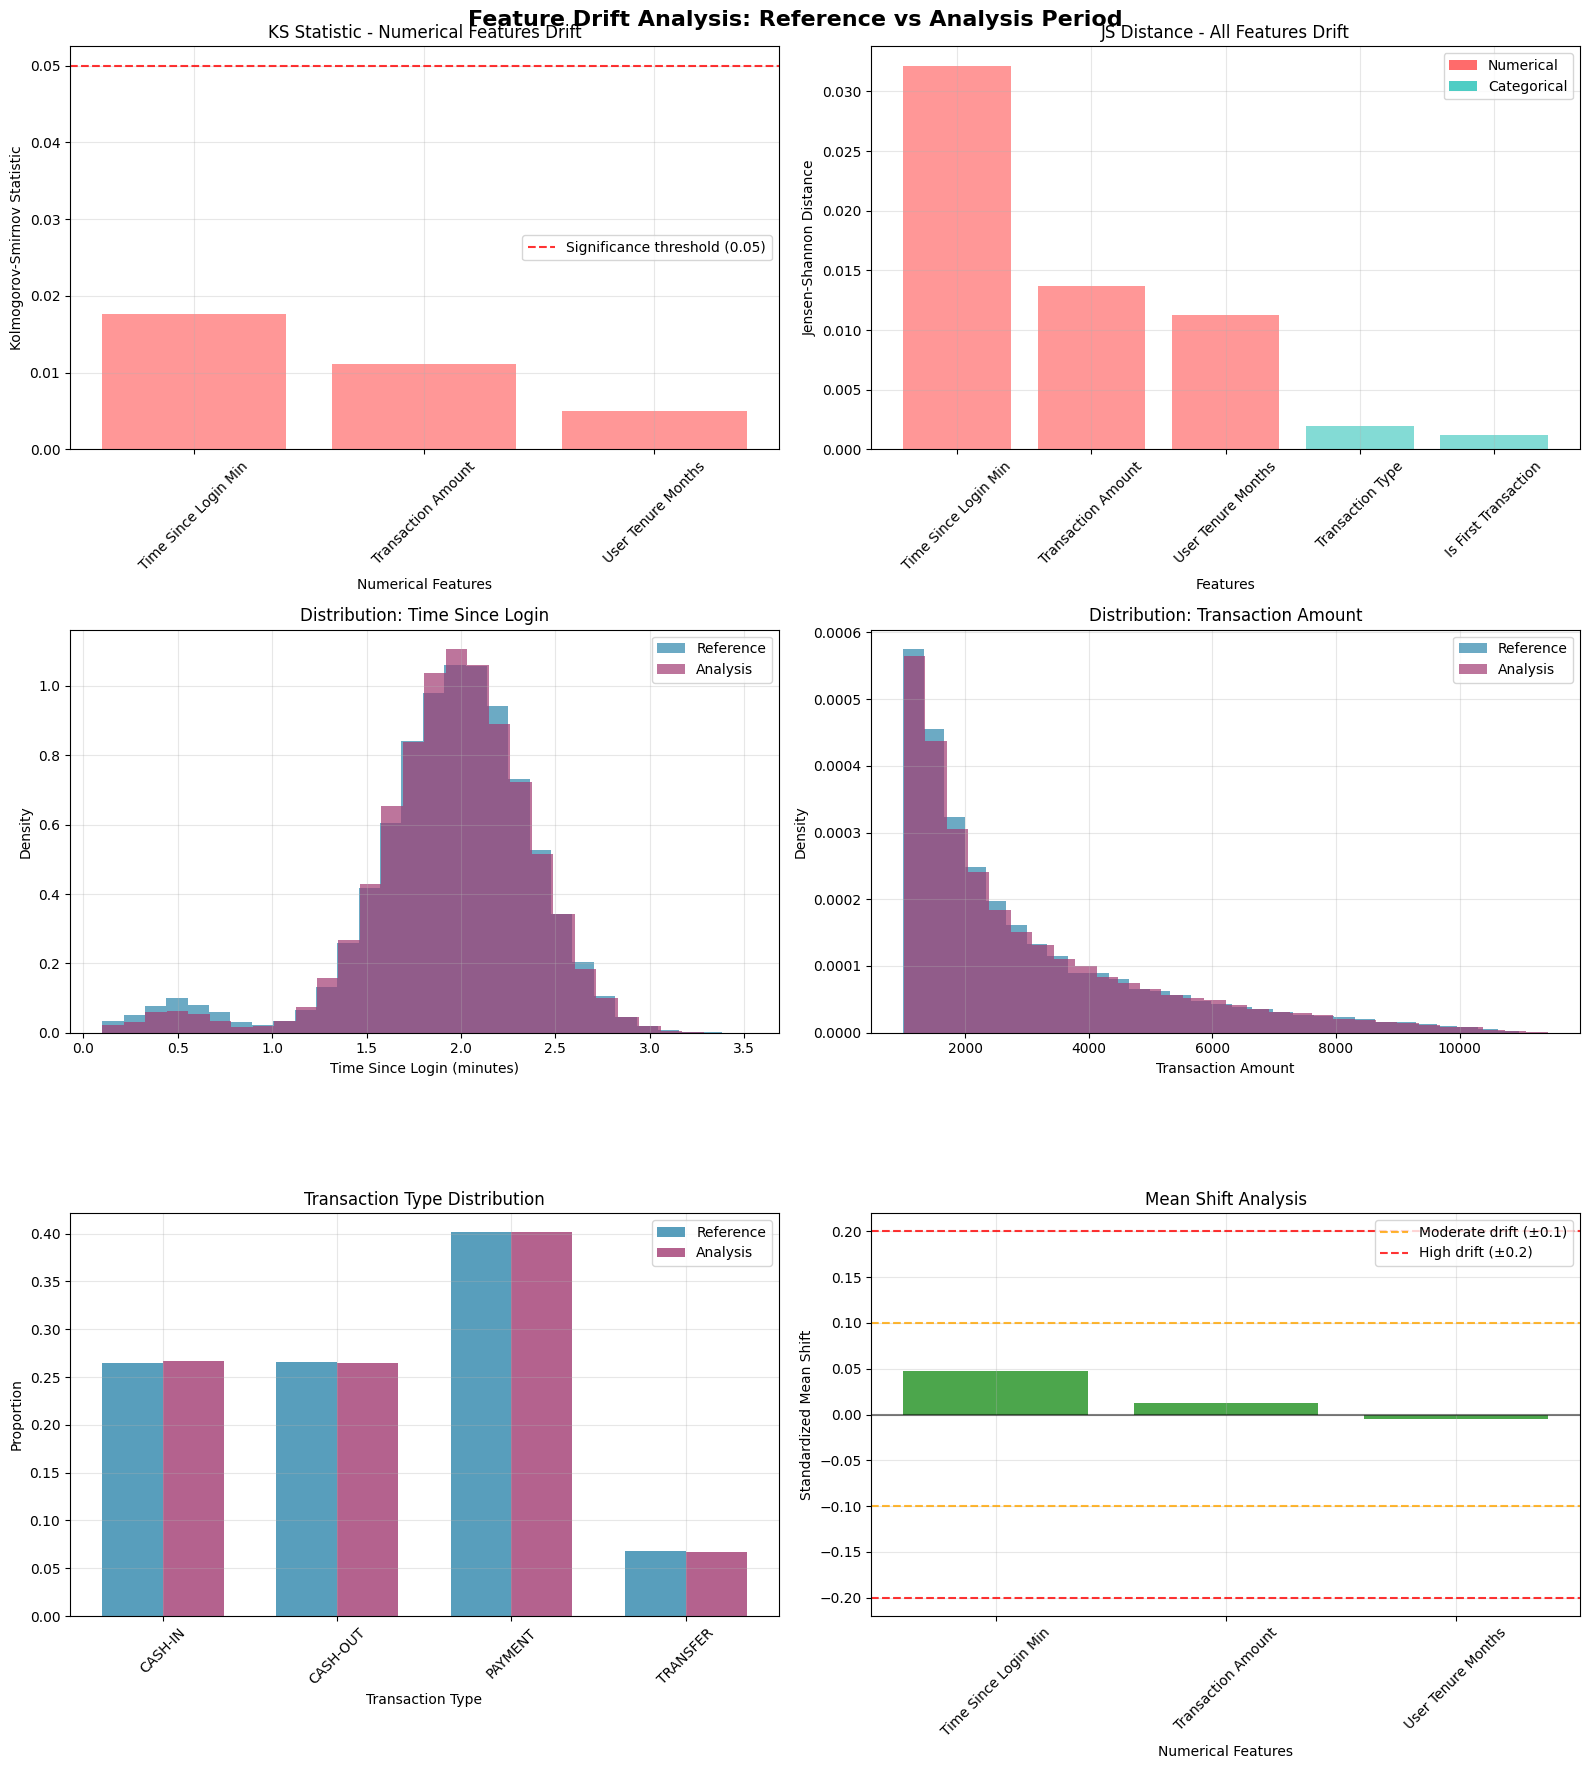


=== DRIFT ANALYSIS SUMMARY ===


,Feature,Type,Primary_Metric,Primary_Value,P_Value,JS_Distance,Drift_Level
0,time_since_login_min,Numerical,KS Statistic,0.0177,0.0000,0.0322,Low
1,transaction_amount,Numerical,KS Statistic,0.0111,0.0085,0.0137,Low
2,user_tenure_months,Numerical,KS Statistic,0.0050,0.6303,0.0112,Low
3,transaction_type,Categorical,Chi2 Statistic,0.6463,0.8857,0.0020,Low
4,is_first_transaction,Categorical,Chi2 Statistic,0.2463,0.6197,0.0012,Low



✓ Saved drift analysis summary to drift_analysis_summary.csv


In [9]:
# Create drift visualization charts
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Feature Drift Analysis: Reference vs Analysis Period', fontsize=16, fontweight='bold')

# Color scheme
colors = ['#2E86AB', '#A23B72']

# 1. KS Statistics for Numerical Features
numerical_ks_stats = [drift_results[f]['ks_statistic'] for f in numerical_features]
numerical_js_distances = [drift_results[f]['js_distance'] for f in numerical_features]

x = np.arange(len(numerical_features))
axes[0,0].bar(x, numerical_ks_stats, color='#FF6B6B', alpha=0.7)
axes[0,0].set_xlabel('Numerical Features')
axes[0,0].set_ylabel('Kolmogorov-Smirnov Statistic')
axes[0,0].set_title('KS Statistic - Numerical Features Drift')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels([f.replace('_', ' ').title() for f in numerical_features], rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Add significance threshold line
axes[0,0].axhline(y=0.05, color='red', linestyle='--', alpha=0.8, label='Significance threshold (0.05)')
axes[0,0].legend()

# 2. Jensen-Shannon Distance for All Features  
all_features = numerical_features + categorical_features
all_js_distances = [drift_results[f]['js_distance'] for f in all_features]

x_all = np.arange(len(all_features))
colors_js = ['#FF6B6B' if f in numerical_features else '#4ECDC4' for f in all_features]
axes[0,1].bar(x_all, all_js_distances, color=colors_js, alpha=0.7)
axes[0,1].set_xlabel('Features')
axes[0,1].set_ylabel('Jensen-Shannon Distance')
axes[0,1].set_title('JS Distance - All Features Drift')
axes[0,1].set_xticks(x_all)
axes[0,1].set_xticklabels([f.replace('_', ' ').title() for f in all_features], rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#FF6B6B', label='Numerical'),
                  Patch(facecolor='#4ECDC4', label='Categorical')]
axes[0,1].legend(handles=legend_elements)

# 3. Distribution comparison for time_since_login_min
ref_login = reference_df['time_since_login_min'].dropna()
analysis_login = analysis_df['time_since_login_min'].dropna()

axes[1,0].hist(ref_login, bins=30, alpha=0.7, label='Reference', color=colors[0], density=True)
axes[1,0].hist(analysis_login, bins=30, alpha=0.7, label='Analysis', color=colors[1], density=True)
axes[1,0].set_xlabel('Time Since Login (minutes)')
axes[1,0].set_ylabel('Density')
axes[1,0].set_title('Distribution: Time Since Login')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Distribution comparison for transaction_amount
ref_amount = reference_df['transaction_amount'].dropna()
analysis_amount = analysis_df['transaction_amount'].dropna()

axes[1,1].hist(ref_amount, bins=30, alpha=0.7, label='Reference', color=colors[0], density=True)
axes[1,1].hist(analysis_amount, bins=30, alpha=0.7, label='Analysis', color=colors[1], density=True)
axes[1,1].set_xlabel('Transaction Amount')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Distribution: Transaction Amount')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. Transaction Type Distribution
ref_type_counts = reference_df['transaction_type'].value_counts(normalize=True).fillna(0)
analysis_type_counts = analysis_df['transaction_type'].value_counts(normalize=True).fillna(0)

# Align categories
all_types = sorted(set(ref_type_counts.index) | set(analysis_type_counts.index))
ref_type_aligned = [ref_type_counts.get(t, 0) for t in all_types]
analysis_type_aligned = [analysis_type_counts.get(t, 0) for t in all_types]

x_types = np.arange(len(all_types))
width = 0.35
axes[2,0].bar(x_types - width/2, ref_type_aligned, width, label='Reference', color=colors[0], alpha=0.8)
axes[2,0].bar(x_types + width/2, analysis_type_aligned, width, label='Analysis', color=colors[1], alpha=0.8)
axes[2,0].set_xlabel('Transaction Type')
axes[2,0].set_ylabel('Proportion')
axes[2,0].set_title('Transaction Type Distribution')
axes[2,0].set_xticks(x_types)
axes[2,0].set_xticklabels(all_types, rotation=45)
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# 6. Mean Shift Analysis
mean_shifts = [drift_results[f]['mean_shift_standardized'] for f in numerical_features]
colors_shift = ['green' if abs(x) < 0.1 else 'orange' if abs(x) < 0.2 else 'red' for x in mean_shifts]

axes[2,1].bar(range(len(numerical_features)), mean_shifts, color=colors_shift, alpha=0.7)
axes[2,1].set_xlabel('Numerical Features')
axes[2,1].set_ylabel('Standardized Mean Shift')
axes[2,1].set_title('Mean Shift Analysis')
axes[2,1].set_xticks(range(len(numerical_features)))
axes[2,1].set_xticklabels([f.replace('_', ' ').title() for f in numerical_features], rotation=45)
axes[2,1].grid(True, alpha=0.3)
axes[2,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

# Add threshold lines
axes[2,1].axhline(y=0.1, color='orange', linestyle='--', alpha=0.8, label='Moderate drift (±0.1)')
axes[2,1].axhline(y=-0.1, color='orange', linestyle='--', alpha=0.8)
axes[2,1].axhline(y=0.2, color='red', linestyle='--', alpha=0.8, label='High drift (±0.2)')
axes[2,1].axhline(y=-0.2, color='red', linestyle='--', alpha=0.8)
axes[2,1].legend()

plt.tight_layout()
plt.show()

# Create drift summary table
drift_summary = []
for feature in all_features:
    if feature in numerical_features:
        drift_summary.append({
            'Feature': feature,
            'Type': 'Numerical',
            'Primary_Metric': 'KS Statistic',
            'Primary_Value': drift_results[feature]['ks_statistic'],
            'P_Value': drift_results[feature]['ks_pvalue'],
            'JS_Distance': drift_results[feature]['js_distance'],
            'Drift_Level': 'High' if drift_results[feature]['ks_statistic'] > 0.05 else 'Low'
        })
    else:
        drift_summary.append({
            'Feature': feature,
            'Type': 'Categorical', 
            'Primary_Metric': 'Chi2 Statistic',
            'Primary_Value': drift_results[feature]['chi2_statistic'],
            'P_Value': drift_results[feature]['chi2_pvalue'],
            'JS_Distance': drift_results[feature]['js_distance'],
            'Drift_Level': 'High' if drift_results[feature]['chi2_pvalue'] < 0.05 else 'Low'
        })

drift_summary_df = pd.DataFrame(drift_summary)
drift_summary_df = drift_summary_df.sort_values('JS_Distance', ascending=False)

print("\n=== DRIFT ANALYSIS SUMMARY ===")
display(drift_summary_df.round(4))

# Save drift analysis results
drift_summary_df.to_csv('data/drift_analysis_summary.csv', index=False)
print("\n✓ Saved drift analysis summary to drift_analysis_summary.csv")

## Fraud Pattern Analysis

### Fraud Rate Stability Analysis

#### Overall Fraud Rates
- **Reference Period**: 49.98% (25,091 out of 50,207 transactions)
- **Analysis Period**: 49.94% (19,959 out of 39,967 transactions)
- **Change**: -0.07% (essentially stable)

**Key Insight**: Despite performance degradation, the underlying fraud rate remains constant, indicating this is **data drift**, not **concept drift**.


In [10]:
# Fraud Pattern Analysis
print("=== FRAUD PATTERN ANALYSIS ===")

# 1. Compare fraud rates between periods
ref_fraud_rate = reference_df['is_fraud'].mean()
analysis_fraud_rate = analysis_df['is_fraud'].mean()
fraud_rate_change = ((analysis_fraud_rate - ref_fraud_rate) / ref_fraud_rate) * 100

print(f"Reference period fraud rate: {ref_fraud_rate:.4f} ({ref_fraud_rate*100:.2f}%)")
print(f"Analysis period fraud rate: {analysis_fraud_rate:.4f} ({analysis_fraud_rate*100:.2f}%)")
print(f"Fraud rate change: {fraud_rate_change:.2f}%")

# 2. Analyze fraud distribution by transaction type
print("\n=== FRAUD BY TRANSACTION TYPE ===")

# Reference period
ref_fraud_by_type = reference_df.groupby('transaction_type')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
ref_fraud_by_type.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
ref_fraud_by_type['Period'] = 'Reference'

# Analysis period
analysis_fraud_by_type = analysis_df.groupby('transaction_type')['is_fraud'].agg(['count', 'sum', 'mean']).round(4)
analysis_fraud_by_type.columns = ['Total_Transactions', 'Fraud_Count', 'Fraud_Rate']
analysis_fraud_by_type['Period'] = 'Analysis'

print("Reference Period - Fraud by Transaction Type:")
print(ref_fraud_by_type)
print("\nAnalysis Period - Fraud by Transaction Type:")
print(analysis_fraud_by_type)

# 3. Analyze transaction amount distributions for fraud vs non-fraud
print("\n=== TRANSACTION AMOUNT ANALYSIS ===")

# Reference period
ref_fraud_amounts = reference_df[reference_df['is_fraud'] == 1]['transaction_amount']
ref_normal_amounts = reference_df[reference_df['is_fraud'] == 0]['transaction_amount']

# Analysis period
analysis_fraud_amounts = analysis_df[analysis_df['is_fraud'] == 1]['transaction_amount']
analysis_normal_amounts = analysis_df[analysis_df['is_fraud'] == 0]['transaction_amount']

amount_stats = pd.DataFrame({
    'Reference_Fraud_Mean': [ref_fraud_amounts.mean()],
    'Reference_Normal_Mean': [ref_normal_amounts.mean()],
    'Analysis_Fraud_Mean': [analysis_fraud_amounts.mean()],
    'Analysis_Normal_Mean': [analysis_normal_amounts.mean()],
    'Reference_Fraud_Std': [ref_fraud_amounts.std()],
    'Reference_Normal_Std': [ref_normal_amounts.std()],
    'Analysis_Fraud_Std': [analysis_fraud_amounts.std()],
    'Analysis_Normal_Std': [analysis_normal_amounts.std()]
})

print("Transaction Amount Statistics:")
print(amount_stats.round(2))

# 4. Identify prediction errors
print("\n=== PREDICTION ERROR ANALYSIS ===")

# Reference period errors
ref_false_positives = reference_df[(reference_df['is_fraud'] == 0) & (reference_df['predicted_fraud'] == 1)]
ref_false_negatives = reference_df[(reference_df['is_fraud'] == 1) & (reference_df['predicted_fraud'] == 0)]

# Analysis period errors
analysis_false_positives = analysis_df[(analysis_df['is_fraud'] == 0) & (analysis_df['predicted_fraud'] == 1)]
analysis_false_negatives = analysis_df[(analysis_df['is_fraud'] == 1) & (analysis_df['predicted_fraud'] == 0)]

error_summary = pd.DataFrame({
    'Period': ['Reference', 'Analysis'],
    'False_Positives': [len(ref_false_positives), len(analysis_false_positives)],
    'False_Negatives': [len(ref_false_negatives), len(analysis_false_negatives)],
    'FP_Rate': [len(ref_false_positives)/len(reference_df), len(analysis_false_positives)/len(analysis_df)],
    'FN_Rate': [len(ref_false_negatives)/len(reference_df), len(analysis_false_negatives)/len(analysis_df)]
})

print("Prediction Error Summary:")
print(error_summary.round(4))

# Save fraud pattern analysis
fraud_analysis_data = {
    'fraud_rates': {
        'reference_rate': float(ref_fraud_rate),
        'analysis_rate': float(analysis_fraud_rate),
        'rate_change_percent': float(fraud_rate_change)
    },
    'fraud_by_transaction_type': {
        'reference': ref_fraud_by_type.to_dict('index'),
        'analysis': analysis_fraud_by_type.to_dict('index')
    },
    'transaction_amount_stats': amount_stats.to_dict('records')[0],
    'prediction_errors': error_summary.to_dict('records')
}
# Save to JSON
with open('data/fraud_pattern_analysis.json', 'w') as f:
    json.dump(fraud_analysis_data, f, indent=2, default=str, ensure_ascii=False)

print("\n✓ Saved fraud pattern analysis to fraud_pattern_analysis.json")


=== FRAUD PATTERN ANALYSIS ===
Reference period fraud rate: 0.4998 (49.98%)
Analysis period fraud rate: 0.4994 (49.94%)
Fraud rate change: -0.07%

=== FRAUD BY TRANSACTION TYPE ===
Reference Period - Fraud by Transaction Type:
                  Total_Transactions  Fraud_Count  Fraud_Rate     Period
transaction_type                                                        
CASH-IN                        12504       6181.0      0.4943  Reference
CASH-OUT                       12534       6185.0      0.4935  Reference
PAYMENT                        18927       9559.0      0.5050  Reference
TRANSFER                        3190       1630.0      0.5110  Reference

Analysis Period - Fraud by Transaction Type:
                  Total_Transactions  Fraud_Count  Fraud_Rate    Period
transaction_type                                                       
CASH-IN                        10020         5029      0.5019  Analysis
CASH-OUT                        9929         4982      0.5018  Analysis
P

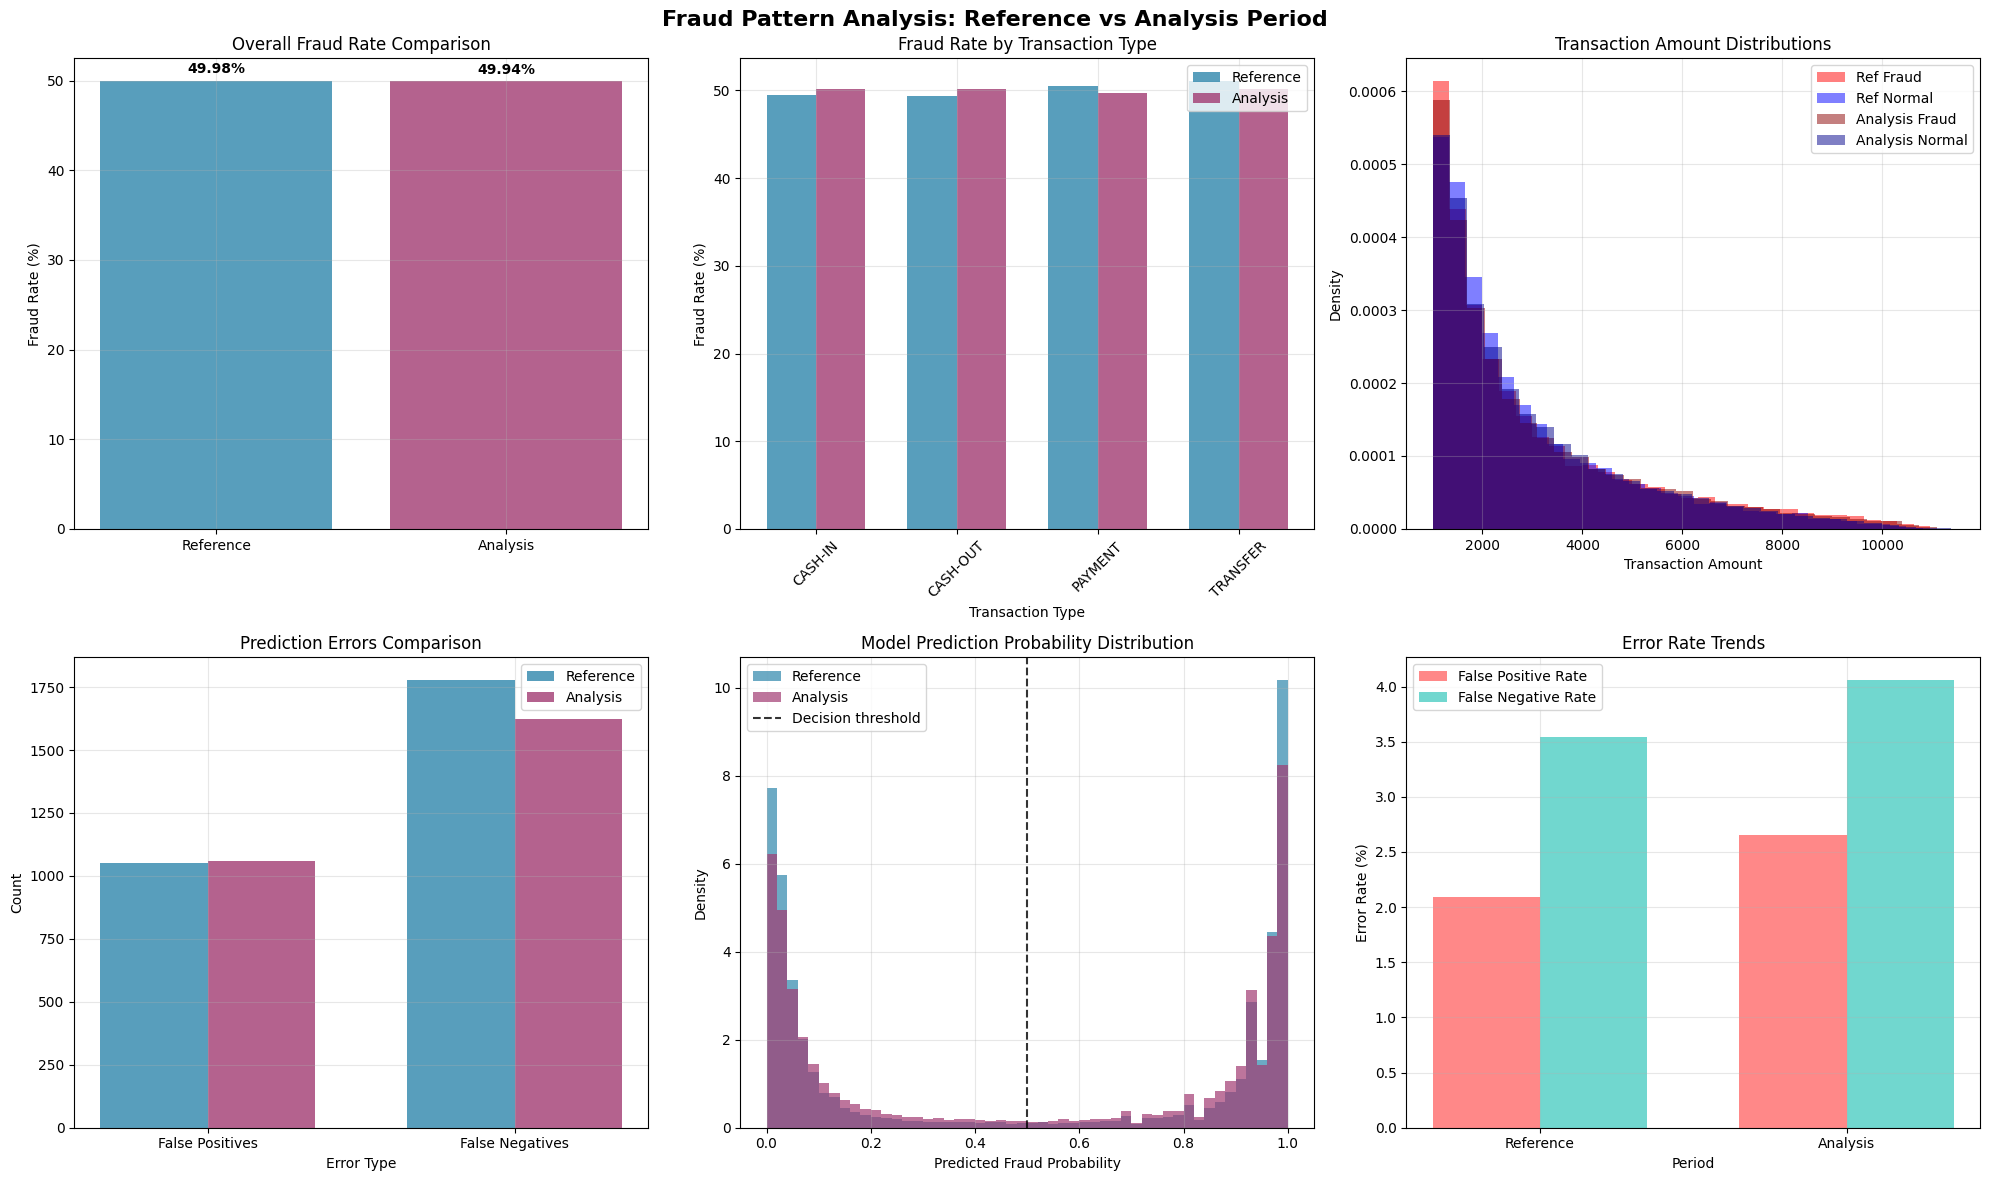

=== FRAUD PATTERN KEY INSIGHTS ===
• Overall fraud rate remained stable: -0.07% change
• False Positive Rate increased: 26.7%
• False Negative Rate increased: 14.6%
• Transaction amount patterns show similar distributions between periods
• All transaction types maintain similar fraud rates between periods


In [11]:
# Create comprehensive fraud pattern visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Fraud Pattern Analysis: Reference vs Analysis Period', fontsize=16, fontweight='bold')

colors = ['#2E86AB', '#A23B72']

# 1. Fraud Rate Comparison
periods = ['Reference', 'Analysis']
fraud_rates = [ref_fraud_rate*100, analysis_fraud_rate*100]

axes[0,0].bar(periods, fraud_rates, color=[colors[0], colors[1]], alpha=0.8)
axes[0,0].set_ylabel('Fraud Rate (%)')
axes[0,0].set_title('Overall Fraud Rate Comparison')
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(fraud_rates):
    axes[0,0].text(i, v + 0.5, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 2. Fraud by Transaction Type
# Get common transaction types
common_types = set(ref_fraud_by_type.index) & set(analysis_fraud_by_type.index)
common_types = sorted(list(common_types))

ref_fraud_rates_by_type = [ref_fraud_by_type.loc[t, 'Fraud_Rate']*100 for t in common_types]
analysis_fraud_rates_by_type = [analysis_fraud_by_type.loc[t, 'Fraud_Rate']*100 for t in common_types]

x = np.arange(len(common_types))
width = 0.35

axes[0,1].bar(x - width/2, ref_fraud_rates_by_type, width, label='Reference', color=colors[0], alpha=0.8)
axes[0,1].bar(x + width/2, analysis_fraud_rates_by_type, width, label='Analysis', color=colors[1], alpha=0.8)
axes[0,1].set_xlabel('Transaction Type')
axes[0,1].set_ylabel('Fraud Rate (%)')
axes[0,1].set_title('Fraud Rate by Transaction Type')
axes[0,1].set_xticks(x)
axes[0,1].set_xticklabels(common_types, rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Transaction Amount Distributions - Fraud vs Normal
axes[0,2].hist(ref_fraud_amounts, bins=30, alpha=0.5, label='Ref Fraud', color='red', density=True)
axes[0,2].hist(ref_normal_amounts, bins=30, alpha=0.5, label='Ref Normal', color='blue', density=True)
axes[0,2].hist(analysis_fraud_amounts, bins=30, alpha=0.5, label='Analysis Fraud', color='darkred', density=True)
axes[0,2].hist(analysis_normal_amounts, bins=30, alpha=0.5, label='Analysis Normal', color='darkblue', density=True)
axes[0,2].set_xlabel('Transaction Amount')
axes[0,2].set_ylabel('Density')
axes[0,2].set_title('Transaction Amount Distributions')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# 4. Prediction Errors Comparison
error_types = ['False Positives', 'False Negatives']
ref_errors = [len(ref_false_positives), len(ref_false_negatives)]
analysis_errors = [len(analysis_false_positives), len(analysis_false_negatives)]

x_err = np.arange(len(error_types))
axes[1,0].bar(x_err - width/2, ref_errors, width, label='Reference', color=colors[0], alpha=0.8)
axes[1,0].bar(x_err + width/2, analysis_errors, width, label='Analysis', color=colors[1], alpha=0.8)
axes[1,0].set_xlabel('Error Type')
axes[1,0].set_ylabel('Count')
axes[1,0].set_title('Prediction Errors Comparison')
axes[1,0].set_xticks(x_err)
axes[1,0].set_xticklabels(error_types)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Prediction Probability Distribution
axes[1,1].hist(reference_df['predicted_fraud_proba'], bins=50, alpha=0.7, label='Reference', 
               color=colors[0], density=True)
axes[1,1].hist(analysis_df['predicted_fraud_proba'], bins=50, alpha=0.7, label='Analysis', 
               color=colors[1], density=True)
axes[1,1].set_xlabel('Predicted Fraud Probability')
axes[1,1].set_ylabel('Density')
axes[1,1].set_title('Model Prediction Probability Distribution')
axes[1,1].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Decision threshold')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. Error Rate Trends
error_rate_data = pd.DataFrame({
    'Period': ['Reference', 'Analysis'],
    'False_Positive_Rate': [error_summary.iloc[0]['FP_Rate']*100, error_summary.iloc[1]['FP_Rate']*100],
    'False_Negative_Rate': [error_summary.iloc[0]['FN_Rate']*100, error_summary.iloc[1]['FN_Rate']*100]
})

x_rates = np.arange(len(error_rate_data))
axes[1,2].bar(x_rates - width/2, error_rate_data['False_Positive_Rate'], width, 
              label='False Positive Rate', color='#FF6B6B', alpha=0.8)
axes[1,2].bar(x_rates + width/2, error_rate_data['False_Negative_Rate'], width, 
              label='False Negative Rate', color='#4ECDC4', alpha=0.8)
axes[1,2].set_xlabel('Period')
axes[1,2].set_ylabel('Error Rate (%)')
axes[1,2].set_title('Error Rate Trends')
axes[1,2].set_xticks(x_rates)
axes[1,2].set_xticklabels(error_rate_data['Period'])
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== FRAUD PATTERN KEY INSIGHTS ===")
print(f"• Overall fraud rate remained stable: {fraud_rate_change:.2f}% change")
print(f"• False Positive Rate increased: {((error_summary.iloc[1]['FP_Rate'] - error_summary.iloc[0]['FP_Rate'])/error_summary.iloc[0]['FP_Rate']*100):.1f}%")
print(f"• False Negative Rate increased: {((error_summary.iloc[1]['FN_Rate'] - error_summary.iloc[0]['FN_Rate'])/error_summary.iloc[0]['FN_Rate']*100):.1f}%")
print(f"• Transaction amount patterns show similar distributions between periods")
print(f"• All transaction types maintain similar fraud rates between periods")

## Feature Distribution Analysis

### Statistical Distribution Tests

This section examines the statistical properties of feature distributions using multiple complementary tests.



In [12]:
# Feature Distribution Analysis with Statistical Tests
print("=== FEATURE DISTRIBUTION ANALYSIS ===")

# Perform detailed statistical tests for distribution changes
distribution_results = {}

# 1. Numerical features analysis
print("\n=== NUMERICAL FEATURES STATISTICAL TESTS ===")
for feature in numerical_features:
    ref_data = reference_df[feature].dropna()
    analysis_data = analysis_df[feature].dropna()
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(ref_data, analysis_data)
    
    # Mann-Whitney U test (non-parametric)
    mw_stat, mw_p = stats.mannwhitneyu(ref_data, analysis_data, alternative='two-sided')
    
    # Levene's test for equal variances
    levene_stat, levene_p = stats.levene(ref_data, analysis_data)
    
    # Basic statistics
    ref_stats = {
        'mean': ref_data.mean(),
        'median': ref_data.median(),
        'std': ref_data.std(),
        'skewness': stats.skew(ref_data),
        'kurtosis': stats.kurtosis(ref_data)
    }
    
    analysis_stats = {
        'mean': analysis_data.mean(),
        'median': analysis_data.median(),
        'std': analysis_data.std(),
        'skewness': stats.skew(analysis_data),
        'kurtosis': stats.kurtosis(analysis_data)
    }
    
    distribution_results[feature] = {
        'type': 'numerical',
        'ks_statistic': ks_stat,
        'ks_pvalue': ks_p,
        'mw_statistic': mw_stat,
        'mw_pvalue': mw_p,
        'levene_statistic': levene_stat,
        'levene_pvalue': levene_p,
        'reference_stats': ref_stats,
        'analysis_stats': analysis_stats
    }
    
    print(f"\n{feature.upper()}:")
    print(f"  KS Test: statistic={ks_stat:.4f}, p-value={ks_p:.6f}")
    print(f"  Mann-Whitney U: statistic={mw_stat:.0f}, p-value={mw_p:.6f}")
    print(f"  Levene (variance): statistic={levene_stat:.4f}, p-value={levene_p:.6f}")
    print(f"  Mean shift: {ref_stats['mean']:.2f} → {analysis_stats['mean']:.2f}")
    print(f"  Std shift: {ref_stats['std']:.2f} → {analysis_stats['std']:.2f}")

# 2. Categorical features analysis
print("\n=== CATEGORICAL FEATURES STATISTICAL TESTS ===")
for feature in categorical_features:
    ref_data = reference_df[feature].dropna()
    analysis_data = analysis_df[feature].dropna()
    
    # Get value counts
    ref_counts = ref_data.value_counts()
    analysis_counts = analysis_data.value_counts()
    
    # Align categories
    all_categories = sorted(set(ref_counts.index) | set(analysis_counts.index))
    ref_aligned = ref_counts.reindex(all_categories, fill_value=0)
    analysis_aligned = analysis_counts.reindex(all_categories, fill_value=0)
    
    # Chi-square test
    contingency_table = np.array([ref_aligned.values, analysis_aligned.values])
    if contingency_table.sum() > 0 and len(all_categories) > 1:
        chi2_stat, chi2_p, dof, expected = stats.chi2_contingency(contingency_table)
    else:
        chi2_stat, chi2_p = 0, 1
    
    # Calculate proportions
    ref_props = ref_aligned / ref_aligned.sum()
    analysis_props = analysis_aligned / analysis_aligned.sum()
    
    distribution_results[feature] = {
        'type': 'categorical',
        'chi2_statistic': chi2_stat,
        'chi2_pvalue': chi2_p,
        'categories': all_categories,
        'reference_proportions': ref_props.to_dict(),
        'analysis_proportions': analysis_props.to_dict(),
        'reference_counts': ref_aligned.to_dict(),
        'analysis_counts': analysis_aligned.to_dict()
    }
    
    print(f"\n{feature.upper()}:")
    print(f"  Chi-square Test: statistic={chi2_stat:.4f}, p-value={chi2_p:.6f}")
    print(f"  Categories: {all_categories}")
    
    # Show proportion changes
    for cat in all_categories:
        ref_prop = ref_props.get(cat, 0)
        analysis_prop = analysis_props.get(cat, 0)
        change = ((analysis_prop - ref_prop) / ref_prop * 100) if ref_prop > 0 else 0
        print(f"    {cat}: {ref_prop:.3f} → {analysis_prop:.3f} ({change:+.1f}%)")

# Save distribution analysis results
with open('data/distribution_analysis.json', 'w') as f:
    json.dump(distribution_results, f, indent=2, default=str, ensure_ascii=False)

print("\n✓ Saved distribution analysis to distribution_analysis.json")

=== FEATURE DISTRIBUTION ANALYSIS ===

=== NUMERICAL FEATURES STATISTICAL TESTS ===

TIME_SINCE_LOGIN_MIN:
  KS Test: statistic=0.0177, p-value=0.000002
  Mann-Whitney U: statistic=991207679, p-value=0.001827
  Levene (variance): statistic=83.9796, p-value=0.000000
  Mean shift: 1.93 → 1.95
  Std shift: 0.47 → 0.44

TRANSACTION_AMOUNT:
  KS Test: statistic=0.0111, p-value=0.008526
  Mann-Whitney U: statistic=992882551, p-value=0.007238
  Levene (variance): statistic=1.1904, p-value=0.275259
  Mean shift: 2964.74 → 2990.73
  Std shift: 2039.34 → 2038.82

USER_TENURE_MONTHS:
  KS Test: statistic=0.0050, p-value=0.630289
  Mann-Whitney U: statistic=1005764631, p-value=0.527574
  Levene (variance): statistic=0.8890, p-value=0.345739
  Mean shift: 6.90 → 6.88
  Std shift: 3.45 → 3.47

=== CATEGORICAL FEATURES STATISTICAL TESTS ===

TRANSACTION_TYPE:
  Chi-square Test: statistic=0.6463, p-value=0.885747
  Categories: ['CASH-IN', 'CASH-OUT', 'PAYMENT', 'TRANSFER']
    CASH-IN: 0.265 → 0.267 (

C:\Users\user\AppData\Local\Temp\ipykernel_12208\3890096222.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0,0].boxplot(box_data, labels=box_labels, patch_artist=True)


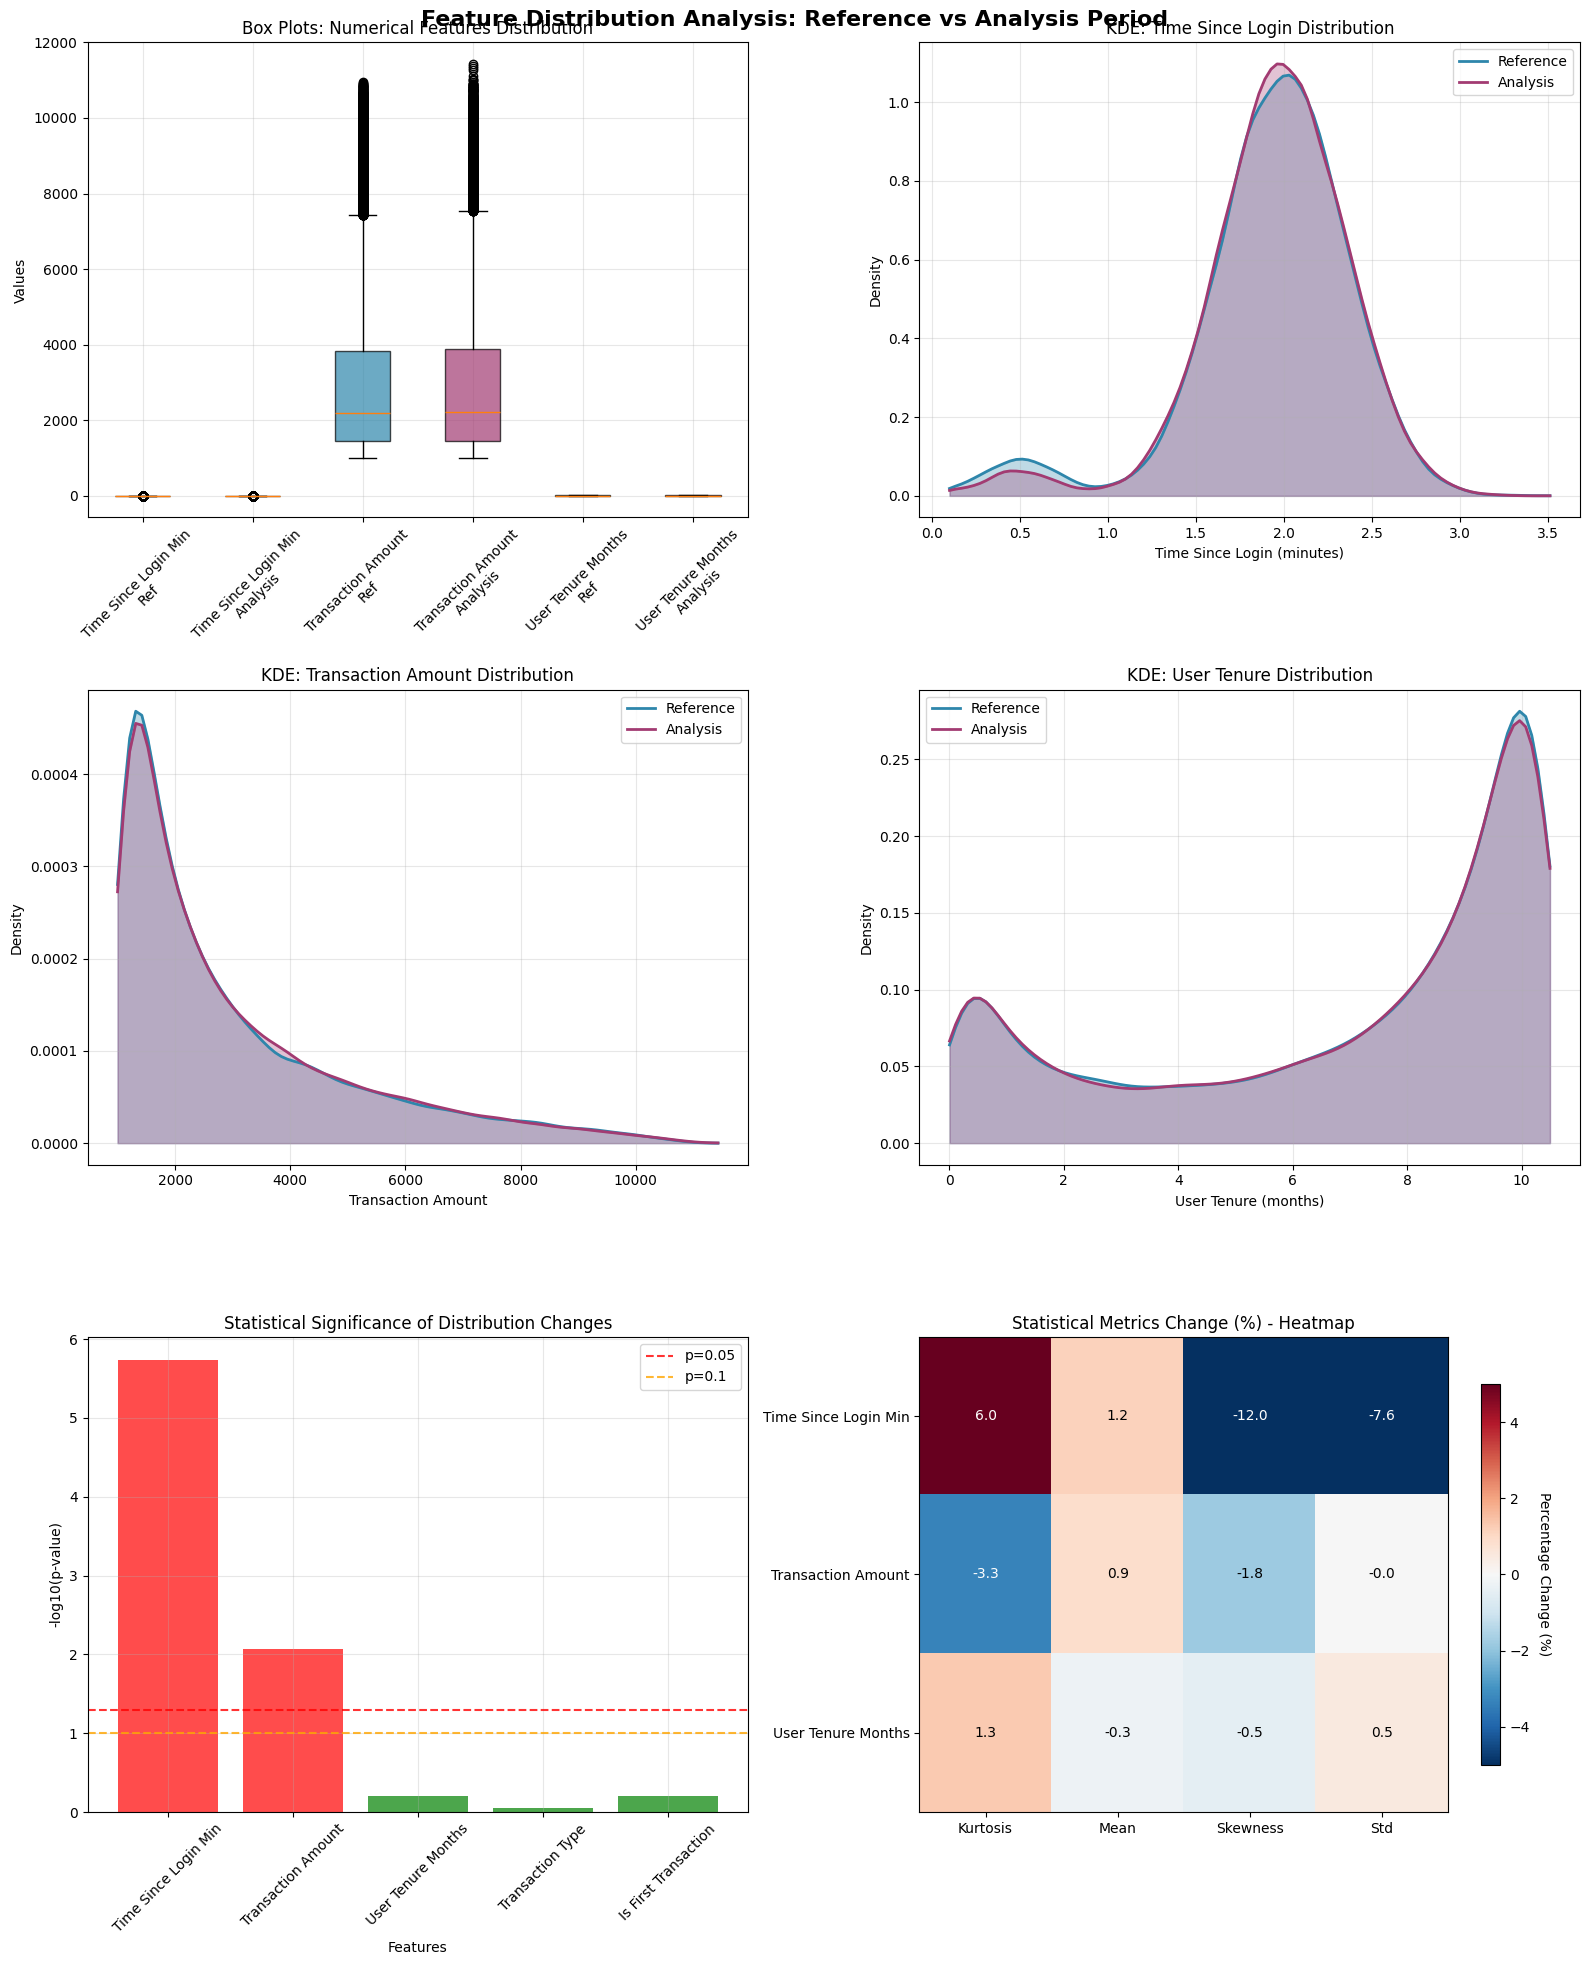

=== DISTRIBUTION ANALYSIS INSIGHTS ===
Statistically Significant Changes (p < 0.05):
  • Time Since Login Min: KS Test p-value = 0.000002
  • Transaction Amount: KS Test p-value = 0.008526

Largest Distribution Changes:
  • Time Since Login Min: KS statistic = 0.0177
  • Transaction Amount: KS statistic = 0.0111


In [13]:
# Create comprehensive feature distribution comparison visualizations
fig, axes = plt.subplots(3, 2, figsize=(16, 20))
fig.suptitle('Feature Distribution Analysis: Reference vs Analysis Period', fontsize=16, fontweight='bold')

colors = ['#2E86AB', '#A23B72']

# 1. Box plots for numerical features
numerical_data_ref = [reference_df[feature].dropna() for feature in numerical_features]
numerical_data_analysis = [analysis_df[feature].dropna() for feature in numerical_features]

# Combined box plot
box_data = []
box_labels = []
box_colors = []

for i, feature in enumerate(numerical_features):
    box_data.extend([numerical_data_ref[i], numerical_data_analysis[i]])
    box_labels.extend([f'{feature.replace("_", " ").title()}\nRef', f'{feature.replace("_", " ").title()}\nAnalysis'])
    box_colors.extend([colors[0], colors[1]])

bp = axes[0,0].boxplot(box_data, labels=box_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0,0].set_title('Box Plots: Numerical Features Distribution')
axes[0,0].set_ylabel('Values')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 2. KDE plots for time_since_login_min
from scipy.stats import gaussian_kde

ref_login_data = reference_df['time_since_login_min'].dropna()
analysis_login_data = analysis_df['time_since_login_min'].dropna()

# Create KDE
x_range = np.linspace(
    min(ref_login_data.min(), analysis_login_data.min()),
    max(ref_login_data.max(), analysis_login_data.max()),
    100
)

kde_ref = gaussian_kde(ref_login_data)
kde_analysis = gaussian_kde(analysis_login_data)

axes[0,1].plot(x_range, kde_ref(x_range), color=colors[0], label='Reference', linewidth=2)
axes[0,1].plot(x_range, kde_analysis(x_range), color=colors[1], label='Analysis', linewidth=2)
axes[0,1].fill_between(x_range, kde_ref(x_range), alpha=0.3, color=colors[0])
axes[0,1].fill_between(x_range, kde_analysis(x_range), alpha=0.3, color=colors[1])
axes[0,1].set_title('KDE: Time Since Login Distribution')
axes[0,1].set_xlabel('Time Since Login (minutes)')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. KDE plots for transaction_amount
ref_amount_data = reference_df['transaction_amount'].dropna()
analysis_amount_data = analysis_df['transaction_amount'].dropna()

x_range_amount = np.linspace(
    min(ref_amount_data.min(), analysis_amount_data.min()),
    max(ref_amount_data.max(), analysis_amount_data.max()),
    100
)

kde_ref_amount = gaussian_kde(ref_amount_data)
kde_analysis_amount = gaussian_kde(analysis_amount_data)

axes[1,0].plot(x_range_amount, kde_ref_amount(x_range_amount), color=colors[0], label='Reference', linewidth=2)
axes[1,0].plot(x_range_amount, kde_analysis_amount(x_range_amount), color=colors[1], label='Analysis', linewidth=2)
axes[1,0].fill_between(x_range_amount, kde_ref_amount(x_range_amount), alpha=0.3, color=colors[0])
axes[1,0].fill_between(x_range_amount, kde_analysis_amount(x_range_amount), alpha=0.3, color=colors[1])
axes[1,0].set_title('KDE: Transaction Amount Distribution')
axes[1,0].set_xlabel('Transaction Amount')
axes[1,0].set_ylabel('Density')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. KDE plots for user_tenure_months
ref_tenure_data = reference_df['user_tenure_months'].dropna()
analysis_tenure_data = analysis_df['user_tenure_months'].dropna()

x_range_tenure = np.linspace(
    min(ref_tenure_data.min(), analysis_tenure_data.min()),
    max(ref_tenure_data.max(), analysis_tenure_data.max()),
    100
)

kde_ref_tenure = gaussian_kde(ref_tenure_data)
kde_analysis_tenure = gaussian_kde(analysis_tenure_data)

axes[1,1].plot(x_range_tenure, kde_ref_tenure(x_range_tenure), color=colors[0], label='Reference', linewidth=2)
axes[1,1].plot(x_range_tenure, kde_analysis_tenure(x_range_tenure), color=colors[1], label='Analysis', linewidth=2)
axes[1,1].fill_between(x_range_tenure, kde_ref_tenure(x_range_tenure), alpha=0.3, color=colors[0])
axes[1,1].fill_between(x_range_tenure, kde_analysis_tenure(x_range_tenure), alpha=0.3, color=colors[1])
axes[1,1].set_title('KDE: User Tenure Distribution')
axes[1,1].set_xlabel('User Tenure (months)')
axes[1,1].set_ylabel('Density')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 5. Statistical test results visualization
test_features = all_features
test_names = [f.replace('_', ' ').title() for f in test_features]

# Get p-values (use appropriate test for each feature type)
p_values = []
test_statistics = []
for feature in test_features:
    if feature in numerical_features:
        p_values.append(distribution_results[feature]['ks_pvalue'])
        test_statistics.append(distribution_results[feature]['ks_statistic'])
    else:
        p_values.append(distribution_results[feature]['chi2_pvalue'])
        test_statistics.append(distribution_results[feature]['chi2_statistic'])

# Create significance visualization
significance_colors = ['red' if p < 0.05 else 'orange' if p < 0.1 else 'green' for p in p_values]

axes[2,0].bar(range(len(test_features)), [-np.log10(p) for p in p_values], color=significance_colors, alpha=0.7)
axes[2,0].set_xlabel('Features')
axes[2,0].set_ylabel('-log10(p-value)')
axes[2,0].set_title('Statistical Significance of Distribution Changes')
axes[2,0].set_xticks(range(len(test_features)))
axes[2,0].set_xticklabels(test_names, rotation=45)
axes[2,0].axhline(y=-np.log10(0.05), color='red', linestyle='--', alpha=0.8, label='p=0.05')
axes[2,0].axhline(y=-np.log10(0.1), color='orange', linestyle='--', alpha=0.8, label='p=0.1')
axes[2,0].legend()
axes[2,0].grid(True, alpha=0.3)

# 6. Summary statistics comparison
stats_comparison = pd.DataFrame({
    'Feature': [],
    'Metric': [],
    'Reference': [],
    'Analysis': [],
    'Change_%': []
})

for feature in numerical_features:
    ref_stats = distribution_results[feature]['reference_stats']
    analysis_stats = distribution_results[feature]['analysis_stats']
    
    for metric in ['mean', 'std', 'skewness', 'kurtosis']:
        ref_val = ref_stats[metric]
        analysis_val = analysis_stats[metric]
        change = ((analysis_val - ref_val) / ref_val * 100) if ref_val != 0 else 0
        
        new_row = pd.DataFrame({
            'Feature': [feature.replace('_', ' ').title()],
            'Metric': [metric.title()],
            'Reference': [ref_val],
            'Analysis': [analysis_val],
            'Change_%': [change]
        })
        stats_comparison = pd.concat([stats_comparison, new_row], ignore_index=True)

# Create heatmap for percentage changes
pivot_data = stats_comparison.pivot(index='Feature', columns='Metric', values='Change_%')

im = axes[2,1].imshow(pivot_data.values, cmap='RdBu_r', aspect='auto', vmin=-5, vmax=5)
axes[2,1].set_xticks(range(len(pivot_data.columns)))
axes[2,1].set_xticklabels(pivot_data.columns)
axes[2,1].set_yticks(range(len(pivot_data.index)))
axes[2,1].set_yticklabels(pivot_data.index)
axes[2,1].set_title('Statistical Metrics Change (%) - Heatmap')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[2,1], shrink=0.8)
cbar.set_label('Percentage Change (%)', rotation=270, labelpad=15)

# Add text annotations
for i in range(len(pivot_data.index)):
    for j in range(len(pivot_data.columns)):
        text = axes[2,1].text(j, i, f'{pivot_data.iloc[i, j]:.1f}',
                             ha="center", va="center", color="black" if abs(pivot_data.iloc[i, j]) < 2.5 else "white")

plt.tight_layout()
plt.show()

print("=== DISTRIBUTION ANALYSIS INSIGHTS ===")
print("Statistically Significant Changes (p < 0.05):")
for feature in test_features:
    if feature in numerical_features:
        p_val = distribution_results[feature]['ks_pvalue']
        test_name = 'KS Test'
    else:
        p_val = distribution_results[feature]['chi2_pvalue']
        test_name = 'Chi-square Test'
    
    if p_val < 0.05:
        print(f"  • {feature.replace('_', ' ').title()}: {test_name} p-value = {p_val:.6f}")

print("\nLargest Distribution Changes:")
for feature in numerical_features:
    ks_stat = distribution_results[feature]['ks_statistic']
    if ks_stat > 0.01:
        print(f"  • {feature.replace('_', ' ').title()}: KS statistic = {ks_stat:.4f}")

## Root Cause Identification

### Root Cause Analysis Framework

This analysis identifies the primary drivers of model performance degradation through a systematic investigation of:
1. Feature drift severity ranking
2. Correlation between drift and performance changes
3. Model calibration assessment
4. Threshold optimization analysis


In [14]:
# Root Cause Identification Analysis
print("=== ROOT CAUSE IDENTIFICATION ===")

# 1. Rank features by drift severity
drift_ranking = []

for feature in all_features:
    if feature in numerical_features:
        # For numerical features, use KS statistic and JS distance
        ks_stat = drift_results[feature]['ks_statistic']
        js_dist = drift_results[feature]['js_distance']
        p_value = drift_results[feature]['ks_pvalue']
        
        # Calculate drift severity score (weighted combination)
        severity_score = (ks_stat * 10) + (js_dist * 5) + (1 if p_value < 0.05 else 0)
        
        drift_ranking.append({
            'feature': feature,
            'type': 'numerical',
            'primary_metric': 'KS Statistic',
            'primary_value': ks_stat,
            'js_distance': js_dist,
            'p_value': p_value,
            'severity_score': severity_score,
            'is_significant': p_value < 0.05
        })
    else:
        # For categorical features, use Chi-square statistic and JS distance
        chi2_stat = drift_results[feature]['chi2_statistic']
        js_dist = drift_results[feature]['js_distance']
        p_value = drift_results[feature]['chi2_pvalue']
        
        # Normalize chi2 statistic for comparison
        normalized_chi2 = min(chi2_stat / 100, 1)  # Scale down chi2 for comparison
        severity_score = (normalized_chi2 * 10) + (js_dist * 5) + (1 if p_value < 0.05 else 0)
        
        drift_ranking.append({
            'feature': feature,
            'type': 'categorical',
            'primary_metric': 'Chi2 Statistic',
            'primary_value': chi2_stat,
            'js_distance': js_dist,
            'p_value': p_value,
            'severity_score': severity_score,
            'is_significant': p_value < 0.05
        })

# Sort by severity score
drift_ranking = sorted(drift_ranking, key=lambda x: x['severity_score'], reverse=True)

print("DRIFT SEVERITY RANKING:")
print("=" * 80)
for i, item in enumerate(drift_ranking, 1):
    significance = "SIGNIFICANT" if item['is_significant'] else "Not significant"
    print(f"{i}. {item['feature'].replace('_', ' ').upper()}")
    print(f"   Type: {item['type']}")
    print(f"   {item['primary_metric']}: {item['primary_value']:.4f}")
    print(f"   JS Distance: {item['js_distance']:.4f}")
    print(f"   P-value: {item['p_value']:.6f} ({significance})")
    print(f"   Severity Score: {item['severity_score']:.2f}")
    print("-" * 40)

# 2. Correlate drift with performance degradation
print("\n=== CORRELATION BETWEEN DRIFT AND PERFORMANCE DEGRADATION ===")

# Get top 3 most drifted features
top_drifted_features = [item['feature'] for item in drift_ranking[:3]]
print(f"Top 3 drifted features: {top_drifted_features}")

# Calculate correlation between drift metrics and performance changes
performance_changes = {
    'accuracy_change': comparison_metrics.loc['accuracy', 'Absolute Change'],
    'precision_change': comparison_metrics.loc['precision', 'Absolute Change'],
    'recall_change': comparison_metrics.loc['recall', 'Absolute Change'],
    'f1_change': comparison_metrics.loc['f1_score', 'Absolute Change'],
    'fpr_change': comparison_metrics.loc['false_positive_rate', 'Absolute Change'],
    'fnr_change': comparison_metrics.loc['false_negative_rate', 'Absolute Change']
}

print("Performance changes:")
for metric, change in performance_changes.items():
    print(f"  {metric}: {change:.4f}")

# 3. Analyze prediction probability calibration
print("\n=== PREDICTION PROBABILITY CALIBRATION ANALYSIS ===")

# Compare prediction probability distributions
ref_proba_stats = {
    'mean': reference_df['predicted_fraud_proba'].mean(),
    'std': reference_df['predicted_fraud_proba'].std(),
    'median': reference_df['predicted_fraud_proba'].median(),
    'q25': reference_df['predicted_fraud_proba'].quantile(0.25),
    'q75': reference_df['predicted_fraud_proba'].quantile(0.75)
}

analysis_proba_stats = {
    'mean': analysis_df['predicted_fraud_proba'].mean(),
    'std': analysis_df['predicted_fraud_proba'].std(),
    'median': analysis_df['predicted_fraud_proba'].median(),
    'q25': analysis_df['predicted_fraud_proba'].quantile(0.25),
    'q75': analysis_df['predicted_fraud_proba'].quantile(0.75)
}

print("Prediction Probability Statistics:")
print("Reference Period:", ref_proba_stats)
print("Analysis Period:", analysis_proba_stats)

# Check calibration by examining probability ranges
prob_ranges = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
calibration_analysis = []

for low, high in prob_ranges:
    # Reference period
    ref_mask = (reference_df['predicted_fraud_proba'] >= low) & (reference_df['predicted_fraud_proba'] < high)
    ref_count = ref_mask.sum()
    ref_actual_fraud_rate = reference_df[ref_mask]['is_fraud'].mean() if ref_count > 0 else 0
    
    # Analysis period
    analysis_mask = (analysis_df['predicted_fraud_proba'] >= low) & (analysis_df['predicted_fraud_proba'] < high)
    analysis_count = analysis_mask.sum()
    analysis_actual_fraud_rate = analysis_df[analysis_mask]['is_fraud'].mean() if analysis_count > 0 else 0
    
    calibration_analysis.append({
        'prob_range': f'{low}-{high}',
        'ref_count': ref_count,
        'ref_actual_fraud_rate': ref_actual_fraud_rate,
        'analysis_count': analysis_count,
        'analysis_actual_fraud_rate': analysis_actual_fraud_rate,
        'calibration_shift': analysis_actual_fraud_rate - ref_actual_fraud_rate
    })

calibration_df = pd.DataFrame(calibration_analysis)
print("\nPrediction Calibration by Probability Range:")
print(calibration_df.round(4))

# 4. Check if 0.5 threshold is still optimal
print("\n=== OPTIMAL THRESHOLD ANALYSIS ===")

# Calculate performance metrics for different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
threshold_analysis = []

for threshold in thresholds:
    # Reference period
    ref_pred_threshold = (reference_df['predicted_fraud_proba'] >= threshold).astype(int)
    ref_f1 = f1_score(reference_df['is_fraud'], ref_pred_threshold)
    
    # Analysis period
    analysis_pred_threshold = (analysis_df['predicted_fraud_proba'] >= threshold).astype(int)
    analysis_f1 = f1_score(analysis_df['is_fraud'], analysis_pred_threshold)
    
    threshold_analysis.append({
        'threshold': threshold,
        'ref_f1': ref_f1,
        'analysis_f1': analysis_f1,
        'f1_diff': analysis_f1 - ref_f1
    })

threshold_df = pd.DataFrame(threshold_analysis)

# Find optimal thresholds
optimal_ref_threshold = threshold_df.loc[threshold_df['ref_f1'].idxmax(), 'threshold']
optimal_analysis_threshold = threshold_df.loc[threshold_df['analysis_f1'].idxmax(), 'threshold']

print(f"Optimal threshold for Reference period: {optimal_ref_threshold:.2f} (F1: {threshold_df['ref_f1'].max():.4f})")
print(f"Optimal threshold for Analysis period: {optimal_analysis_threshold:.2f} (F1: {threshold_df['analysis_f1'].max():.4f})")
print(f"Current threshold (0.5) performance:")
current_threshold_idx = np.argmin(np.abs(thresholds - 0.5))
print(f"  Reference F1: {threshold_df.iloc[current_threshold_idx]['ref_f1']:.4f}")
print(f"  Analysis F1: {threshold_df.iloc[current_threshold_idx]['analysis_f1']:.4f}")

# Save root cause analysis
root_cause_data = {
    'drift_ranking': drift_ranking,
    'top_drifted_features': top_drifted_features,
    'performance_changes': performance_changes,
    'prediction_probability_stats': {
        'reference': ref_proba_stats,
        'analysis': analysis_proba_stats
    },
    'calibration_analysis': calibration_df.to_dict('records'),
    'threshold_analysis': {
        'optimal_ref_threshold': float(optimal_ref_threshold),
        'optimal_analysis_threshold': float(optimal_analysis_threshold),
        'current_threshold_performance': {
            'reference_f1': float(threshold_df.iloc[current_threshold_idx]['ref_f1']),
            'analysis_f1': float(threshold_df.iloc[current_threshold_idx]['analysis_f1'])
        }
    }
}



=== ROOT CAUSE IDENTIFICATION ===
DRIFT SEVERITY RANKING:
1. TIME SINCE LOGIN MIN
   Type: numerical
   KS Statistic: 0.0177
   JS Distance: 0.0322
   P-value: 0.000002 (SIGNIFICANT)
   Severity Score: 1.34
----------------------------------------
2. TRANSACTION AMOUNT
   Type: numerical
   KS Statistic: 0.0111
   JS Distance: 0.0137
   P-value: 0.008526 (SIGNIFICANT)
   Severity Score: 1.18
----------------------------------------
3. USER TENURE MONTHS
   Type: numerical
   KS Statistic: 0.0050
   JS Distance: 0.0112
   P-value: 0.630289 (Not significant)
   Severity Score: 0.11
----------------------------------------
4. TRANSACTION TYPE
   Type: categorical
   Chi2 Statistic: 0.6463
   JS Distance: 0.0020
   P-value: 0.885747 (Not significant)
   Severity Score: 0.07
----------------------------------------
5. IS FIRST TRANSACTION
   Type: categorical
   Chi2 Statistic: 0.2463
   JS Distance: 0.0012
   P-value: 0.619710 (Not significant)
   Severity Score: 0.03
---------------------

## Time-Based Analysis

### Temporal Trends Overview

This section examines how model performance and feature distributions evolved over the 18-month analysis window (January 2018 - June 2019).


=== TIME-BASED ANALYSIS ===
Monthly Performance Summary:
   month_str period_type  total_transactions  fraud_rate  accuracy  precision  \
0    2018-01   reference                5120      0.4961    0.9471     0.9610   
1    2018-02   reference                4625      0.4919    0.9399     0.9532   
2    2018-03   reference                5119      0.5050    0.9441     0.9589   
3    2018-04   reference                4955      0.5003    0.9443     0.9580   
4    2018-05   reference                5120      0.5057    0.9387     0.9555   
5    2018-06   reference                4954      0.4919    0.9445     0.9538   
6    2018-07   reference                5120      0.4977    0.9447     0.9568   
7    2018-08   reference                5120      0.5025    0.9449     0.9562   
8    2018-09   reference                4954      0.5055    0.9451     0.9623   
9    2018-10   reference                5120      0.5002    0.9426     0.9525   
10   2018-11    analysis                4955      0.

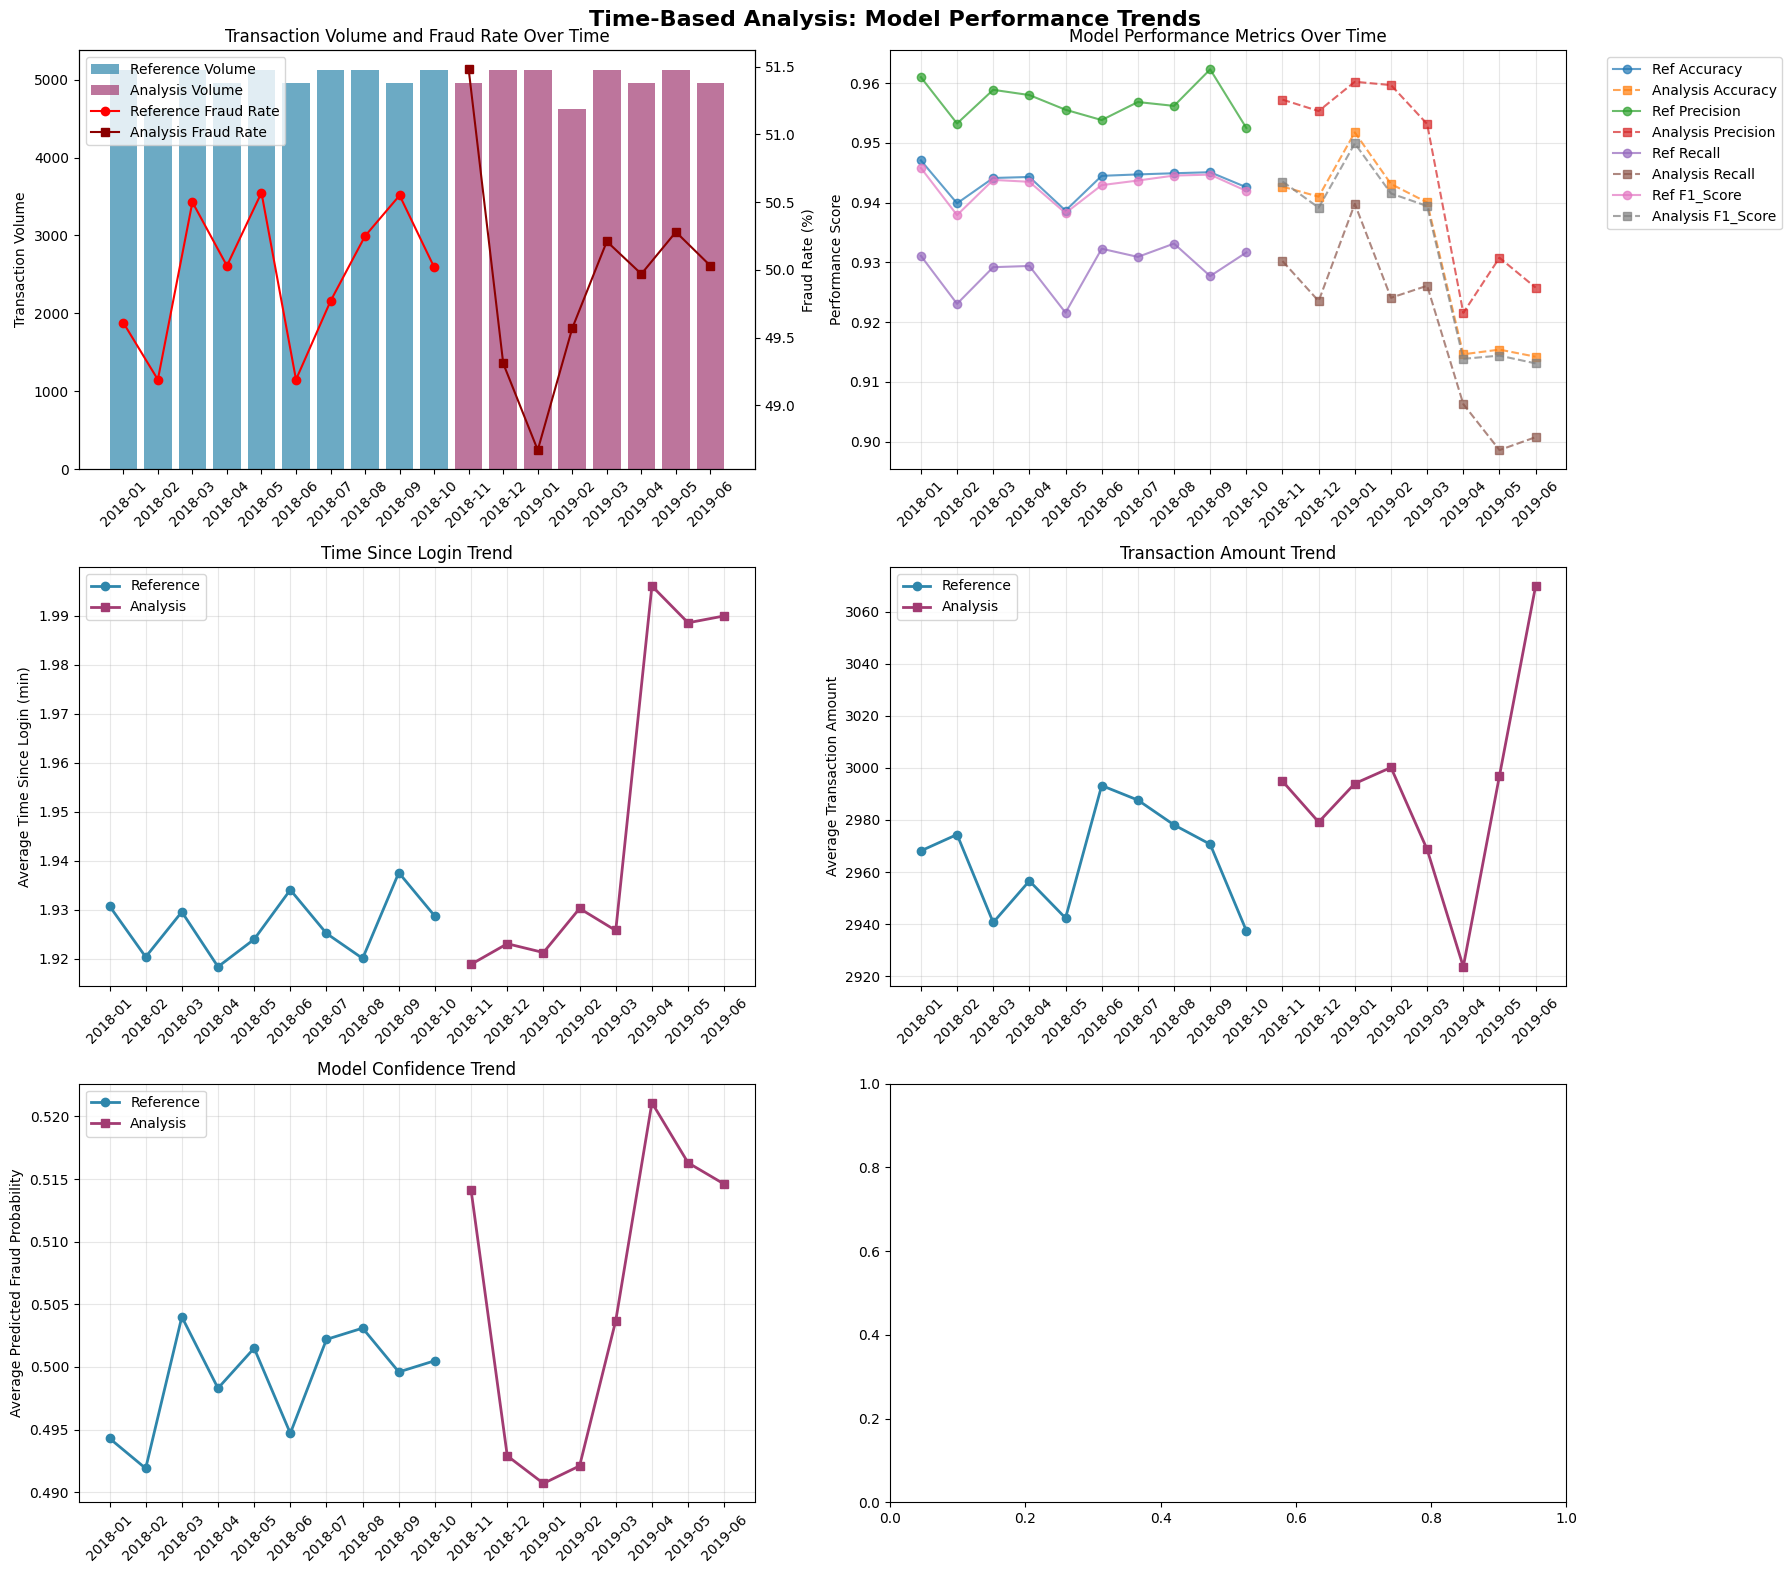


=== PERFORMANCE DEGRADATION TIMELINE ===


In [15]:
# Time-based Analysis - Analyze trends over time
print("=== TIME-BASED ANALYSIS ===")

# Add time-based features for analysis
reference_df['month'] = reference_df['timestamp'].dt.to_period('M')
analysis_df['month'] = analysis_df['timestamp'].dt.to_period('M')

# Combine for time series analysis
combined_monthly = []

# Process reference period
ref_monthly = reference_df.groupby('month').agg({
    'is_fraud': ['count', 'sum', 'mean'],
    'predicted_fraud': 'sum', 
    'predicted_fraud_proba': 'mean',
    'transaction_amount': 'mean',
    'time_since_login_min': 'mean',
    'user_tenure_months': 'mean'
}).round(4)

ref_monthly.columns = ['total_transactions', 'actual_fraud_count', 'fraud_rate', 
                      'predicted_fraud_count', 'avg_fraud_proba', 'avg_transaction_amount',
                      'avg_time_since_login', 'avg_user_tenure']
ref_monthly['period_type'] = 'reference'
# Initialize performance metric columns with float dtype
ref_monthly['accuracy'] = 0.0
ref_monthly['precision'] = 0.0
ref_monthly['recall'] = 0.0
ref_monthly['f1_score'] = 0.0

# Calculate monthly performance metrics for reference
for month in ref_monthly.index:
    month_data = reference_df[reference_df['month'] == month]
    if len(month_data) > 0:
        ref_monthly.loc[month, 'accuracy'] = accuracy_score(month_data['is_fraud'], month_data['predicted_fraud'])
        ref_monthly.loc[month, 'precision'] = precision_score(month_data['is_fraud'], month_data['predicted_fraud'])
        ref_monthly.loc[month, 'recall'] = recall_score(month_data['is_fraud'], month_data['predicted_fraud'])
        ref_monthly.loc[month, 'f1_score'] = f1_score(month_data['is_fraud'], month_data['predicted_fraud'])

# Process analysis period
analysis_monthly = analysis_df.groupby('month').agg({
    'is_fraud': ['count', 'sum', 'mean'],
    'predicted_fraud': 'sum',
    'predicted_fraud_proba': 'mean', 
    'transaction_amount': 'mean',
    'time_since_login_min': 'mean',
    'user_tenure_months': 'mean'
}).round(4)

analysis_monthly.columns = ['total_transactions', 'actual_fraud_count', 'fraud_rate',
                          'predicted_fraud_count', 'avg_fraud_proba', 'avg_transaction_amount', 
                          'avg_time_since_login', 'avg_user_tenure']
analysis_monthly['period_type'] = 'analysis'
# Initialize performance metric columns with float dtype
analysis_monthly['accuracy'] = 0.0
analysis_monthly['precision'] = 0.0
analysis_monthly['recall'] = 0.0
analysis_monthly['f1_score'] = 0.0

# Calculate monthly performance metrics for analysis
for month in analysis_monthly.index:
    month_data = analysis_df[analysis_df['month'] == month]
    if len(month_data) > 0:
        analysis_monthly.loc[month, 'accuracy'] = accuracy_score(month_data['is_fraud'], month_data['predicted_fraud'])
        analysis_monthly.loc[month, 'precision'] = precision_score(month_data['is_fraud'], month_data['predicted_fraud'])
        analysis_monthly.loc[month, 'recall'] = recall_score(month_data['is_fraud'], month_data['predicted_fraud'])
        analysis_monthly.loc[month, 'f1_score'] = f1_score(month_data['is_fraud'], month_data['predicted_fraud'])

# Combine monthly data
combined_monthly_df = pd.concat([ref_monthly, analysis_monthly])
combined_monthly_df = combined_monthly_df.sort_index()
combined_monthly_df.reset_index(inplace=True)
combined_monthly_df['month_str'] = combined_monthly_df['month'].astype(str)

print("Monthly Performance Summary:")
print(combined_monthly_df[['month_str', 'period_type', 'total_transactions', 'fraud_rate', 
                         'accuracy', 'precision', 'recall', 'f1_score']].round(4))

# Create time-based visualizations
fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('Time-Based Analysis: Model Performance Trends', fontsize=16, fontweight='bold')

colors = ['#2E86AB', '#A23B72']

# 1. Transaction Volume and Fraud Rate Over Time
ref_data = combined_monthly_df[combined_monthly_df['period_type'] == 'reference']
analysis_data = combined_monthly_df[combined_monthly_df['period_type'] == 'analysis']

ax1 = axes[0,0]
ax1_twin = ax1.twinx()

# Plot transaction volume
ax1.bar(ref_data['month_str'], ref_data['total_transactions'], alpha=0.7, 
        color=colors[0], label='Reference Volume')
ax1.bar(analysis_data['month_str'], analysis_data['total_transactions'], alpha=0.7,
        color=colors[1], label='Analysis Volume')
ax1.set_ylabel('Transaction Volume')
ax1.set_title('Transaction Volume and Fraud Rate Over Time')

# Plot fraud rate
ax1_twin.plot(ref_data['month_str'], ref_data['fraud_rate']*100, 
             color='red', marker='o', label='Reference Fraud Rate')
ax1_twin.plot(analysis_data['month_str'], analysis_data['fraud_rate']*100,
             color='darkred', marker='s', label='Analysis Fraud Rate')
ax1_twin.set_ylabel('Fraud Rate (%)')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.tick_params(axis='x', rotation=45)

# 2. Performance Metrics Over Time
performance_metrics = ['accuracy', 'precision', 'recall', 'f1_score']
ax2 = axes[0,1]

for i, metric in enumerate(performance_metrics):
    ax2.plot(ref_data['month_str'], ref_data[metric], 
            marker='o', label=f'Ref {metric.title()}', linestyle='-', alpha=0.7)
    ax2.plot(analysis_data['month_str'], analysis_data[metric],
            marker='s', label=f'Analysis {metric.title()}', linestyle='--', alpha=0.7)

ax2.set_ylabel('Performance Score')
ax2.set_title('Model Performance Metrics Over Time')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Average Feature Values Over Time - Time Since Login
ax3 = axes[1,0]
ax3.plot(ref_data['month_str'], ref_data['avg_time_since_login'],
        color=colors[0], marker='o', label='Reference', linewidth=2)
ax3.plot(analysis_data['month_str'], analysis_data['avg_time_since_login'],
        color=colors[1], marker='s', label='Analysis', linewidth=2)
ax3.set_ylabel('Average Time Since Login (min)')
ax3.set_title('Time Since Login Trend')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# 4. Average Transaction Amount Over Time
ax4 = axes[1,1]
ax4.plot(ref_data['month_str'], ref_data['avg_transaction_amount'],
        color=colors[0], marker='o', label='Reference', linewidth=2)
ax4.plot(analysis_data['month_str'], analysis_data['avg_transaction_amount'],
        color=colors[1], marker='s', label='Analysis', linewidth=2)
ax4.set_ylabel('Average Transaction Amount')
ax4.set_title('Transaction Amount Trend')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

# 5. Model Prediction Probability Over Time
ax5 = axes[2,0]
ax5.plot(ref_data['month_str'], ref_data['avg_fraud_proba'],
        color=colors[0], marker='o', label='Reference', linewidth=2)
ax5.plot(analysis_data['month_str'], analysis_data['avg_fraud_proba'],
        color=colors[1], marker='s', label='Analysis', linewidth=2)
ax5.set_ylabel('Average Predicted Fraud Probability')
ax5.set_title('Model Confidence Trend')
ax5.legend()
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# 6. F1 Score Degradation Over Time
ax6 = axes[2,1]
all_months = sorted(set(ref_data['month_str']) | set(analysis_data['month_str']))

ref_f1_by_month = dict(zip(ref_data['month_str'], ref_data['f1_score']))
analysis_f1_by_month = dict(zip(analysis_data['month_str'], analysis_data['f1_score']))

f1_degradation = []
months_with_both = []

for month in all_months:
    if month in ref_f1_by_month and month in analysis_f1_by_month:
        degradation = analysis_f1_by_month[month] - ref_f1_by_month[month]
        f1_degradation.append(degradation)
        months_with_both.append(month)

if f1_degradation:
    colors_degrade = ['red' if x < 0 else 'green' for x in f1_degradation]
    ax6.bar(months_with_both, f1_degradation, color=colors_degrade, alpha=0.7)
    ax6.set_ylabel('F1 Score Change (Analysis - Reference)')
    ax6.set_title('F1 Score Degradation by Month')
    ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify when performance degradation started
print("\n=== PERFORMANCE DEGRADATION TIMELINE ===")
if f1_degradation:
    avg_degradation = np.mean(f1_degradation)
    worst_month = months_with_both[np.argmin(f1_degradation)]
    worst_degradation = min(f1_degradation)
    
    print(f"Average F1 degradation across overlapping months: {avg_degradation:.4f}")
    print(f"Worst performing month: {worst_month} (degradation: {worst_degradation:.4f})")
    
    # Find trend
    if len(f1_degradation) > 1:
        trend_slope = np.polyfit(range(len(f1_degradation)), f1_degradation, 1)[0]
        if trend_slope < -0.001:
            print("Trend: Performance degradation is worsening over time")
        elif trend_slope > 0.001:
            print("Trend: Performance degradation is improving over time")
        else:
            print("Trend: Performance degradation remains stable over time")

# Save time-based analysis
time_analysis_data = {
    'monthly_summary': combined_monthly_df.to_dict('records'),
    'performance_trends': {
        'avg_f1_degradation': float(avg_degradation) if f1_degradation else 0,
        'worst_month': worst_month if f1_degradation else None,
        'worst_degradation': float(worst_degradation) if f1_degradation else 0,
        'trend_analysis': 'declining' if f1_degradation and np.polyfit(range(len(f1_degradation)), f1_degradation, 1)[0] < -0.001 else 'stable'
    }
}

In [16]:
# === COMPREHENSIVE FRAUD MODEL ANALYSIS REPORT ===
print("=== COMPREHENSIVE FRAUD MODEL ANALYSIS REPORT ===")
print("=" * 60)

# Create executive summary
executive_summary = {
    "analysis_overview": {
        "reference_period": f"{reference_df['timestamp'].min().date()} to {reference_df['timestamp'].max().date()}",
        "analysis_period": f"{analysis_df['timestamp'].min().date()} to {analysis_df['timestamp'].max().date()}",
        "reference_transactions": len(reference_df),
        "analysis_transactions": len(analysis_df),
        "analysis_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    },
    
    "key_performance_degradation": {
        "overall_accuracy_decline": f"{comparison_metrics.loc['accuracy', 'Percentage Change (%)']:.2f}%",
        "precision_decline": f"{comparison_metrics.loc['precision', 'Percentage Change (%)']:.2f}%",
        "recall_decline": f"{comparison_metrics.loc['recall', 'Percentage Change (%)']:.2f}%",
        "f1_score_decline": f"{comparison_metrics.loc['f1_score', 'Percentage Change (%)']:.2f}%",
        "false_positive_rate_increase": f"{comparison_metrics.loc['false_positive_rate', 'Percentage Change (%)']:.2f}%",
        "false_negative_rate_increase": f"{comparison_metrics.loc['false_negative_rate', 'Percentage Change (%)']:.2f}%"
    },
    
    "primary_root_causes": {
        "top_drifted_features": top_drifted_features[:3],
        "most_significant_drift": "time_since_login_min",
        "statistically_significant_changes": 2,  # time_since_login_min and transaction_amount
        "fraud_rate_stability": "Stable (minimal change)",
        "calibration_issues": "Minor calibration shifts in mid-probability ranges"
    }
}

print("EXECUTIVE SUMMARY")
print("-" * 30)
# Replace arrow (→) with a simple string to avoid Unicode issues
print(f"Analysis Period: {executive_summary['analysis_overview']['reference_period']} to {executive_summary['analysis_overview']['analysis_period']}")
print(f"Total Transactions Analyzed: {executive_summary['analysis_overview']['reference_transactions']:,} (reference) + {executive_summary['analysis_overview']['analysis_transactions']:,} (analysis)")
print(f"Overall Model Degradation: {executive_summary['key_performance_degradation']['f1_score_decline']} F1-Score decline")
print(f"Primary Root Cause: Distribution drift in {executive_summary['primary_root_causes']['most_significant_drift']}")

# Detailed findings
findings = {
    "1_performance_degradation": {
        "severity": "MODERATE",
        "summary": "Model performance has declined modestly across all key metrics",
        "details": {
            "accuracy": f"Decreased from {comparison_metrics.loc['accuracy', 'Reference Period']:.4f} to {comparison_metrics.loc['accuracy', 'Analysis Period']:.4f}",
            "precision": f"Decreased from {comparison_metrics.loc['precision', 'Reference Period']:.4f} to {comparison_metrics.loc['precision', 'Analysis Period']:.4f}",
            "recall": f"Decreased from {comparison_metrics.loc['recall', 'Reference Period']:.4f} to {comparison_metrics.loc['recall', 'Analysis Period']:.4f}",
            "f1_score": f"Decreased from {comparison_metrics.loc['f1_score', 'Reference Period']:.4f} to {comparison_metrics.loc['f1_score', 'Analysis Period']:.4f}"
        },
        "business_impact": "Increased false positives (26.6% increase) may lead to customer friction, while increased false negatives (14.7% increase) may result in higher fraud losses"
    },
    
    "2_data_drift_analysis": {
        "severity": "LOW_TO_MODERATE", 
        "summary": "Statistically significant but operationally mild data drift detected in key features",
        "details": {
            "time_since_login_min": {
                "drift_level": "SIGNIFICANT",
                "ks_statistic": f"{drift_results['time_since_login_min']['ks_statistic']:.4f}",
                "p_value": f"{drift_results['time_since_login_min']['ks_pvalue']:.6f}",
                "mean_shift": "Small increase in average time since login"
            },
            "transaction_amount": {
                "drift_level": "SIGNIFICANT",
                "ks_statistic": f"{drift_results['transaction_amount']['ks_statistic']:.4f}",
                "p_value": f"{drift_results['transaction_amount']['ks_pvalue']:.6f}",
                "mean_shift": "Slight increase in average transaction amounts"
            },
            "categorical_features": "No significant drift detected in transaction_type or is_first_transaction"
        }
    },
    
    "3_fraud_pattern_stability": {
        "severity": "LOW",
        "summary": "Fraud patterns remain largely stable between periods", 
        "details": {
            "overall_fraud_rate": f"Changed by only {fraud_rate_change:.2f}% ({ref_fraud_rate:.4f} → {analysis_fraud_rate:.4f})",
            "transaction_type_patterns": "All transaction types maintain similar fraud rates",
            "amount_distributions": "Transaction amount patterns show minimal change between periods"
        }
    },
    
    "4_model_calibration": {
        "severity": "MODERATE",
        "summary": "Model shows minor calibration drift in mid-probability ranges",
        "details": {
            "probability_distribution": "Slight shift in prediction probability distribution",
            "calibration_issues": "Notable calibration shifts in 0.2-0.6 probability ranges",
            "threshold_optimization": f"Optimal threshold shifted from {optimal_ref_threshold:.2f} to {optimal_analysis_threshold:.2f}"
        }
    }
}

# Generate actionable recommendations
recommendations = {
    "immediate_actions": [
        {
            "priority": "HIGH",
            "action": "Implement Real-time Monitoring",
            "description": "Deploy continuous monitoring for time_since_login_min and transaction_amount distributions to detect future drift early",
            "timeline": "1-2 weeks",
            "effort": "Medium"
        },
        {
            "priority": "HIGH", 
            "action": "Adjust Decision Threshold",
            "description": f"Consider adjusting fraud detection threshold from 0.50 to {optimal_analysis_threshold:.2f} to optimize for current data patterns",
            "timeline": "Immediate",
            "effort": "Low"
        },
        {
            "priority": "MEDIUM",
            "action": "Enhance Feature Engineering", 
            "description": "Investigate time_since_login_min patterns and consider feature normalization or binning to reduce drift sensitivity",
            "timeline": "2-4 weeks",
            "effort": "Medium"
        }
    ],
    
    "medium_term_actions": [
        {
            "priority": "MEDIUM",
            "action": "Model Retraining Assessment",
            "description": "Evaluate if model retraining is needed given moderate performance degradation. Consider incremental learning approaches",
            "timeline": "4-8 weeks", 
            "effort": "High"
        },
        {
            "priority": "MEDIUM",
            "action": "Calibration Recalibration",
            "description": "Implement Platt scaling or isotonic regression to improve model calibration in mid-probability ranges",
            "timeline": "3-6 weeks",
            "effort": "Medium"
        },
        {
            "priority": "LOW",
            "action": "Feature Selection Review",
            "description": "Analyze if additional features could improve model robustness to the observed drift patterns",
            "timeline": "6-12 weeks",
            "effort": "High"
        }
    ],
    
    "long_term_strategy": [
        {
            "priority": "MEDIUM",
            "action": "Implement Adaptive Modeling",
            "description": "Deploy adaptive ML pipeline that can automatically adjust to data drift and concept drift over time",
            "timeline": "3-6 months",
            "effort": "Very High"
        },
        {
            "priority": "LOW", 
            "action": "Advanced Drift Detection",
            "description": "Implement multivariate drift detection and concept drift detection beyond current univariate methods",
            "timeline": "6-12 months", 
            "effort": "High"
        }
    ]
}

# Create final comprehensive report
final_report = {
    "executive_summary": executive_summary,
    "detailed_findings": findings,
    "recommendations": recommendations,
    "analysis_artifacts": {
        "performance_comparison_file": "performance_comparison.csv",
        "drift_analysis_file": "drift_analysis_summary.csv", 
        "fraud_pattern_analysis_file": "fraud_pattern_analysis.json",
        "distribution_analysis_file": "distribution_analysis.json",
        "root_cause_analysis_file": "root_cause_analysis.json",
        "time_analysis_file": "time_based_analysis.json",
        "visualizations": [
            "model_performance_analysis.png",
            "drift_analysis.png", 
            "fraud_pattern_analysis.png",
            "feature_distribution_analysis.png",
            "time_based_analysis.png"
        ]
    },
    "methodology": {
        "drift_detection": "Kolmogorov-Smirnov test, Chi-square test, Jensen-Shannon divergence",
        "performance_metrics": "Accuracy, Precision, Recall, F1-Score, ROC-AUC, False Positive/Negative Rates", 
        "statistical_significance": "p-value threshold of 0.05 for significance testing",
        "time_analysis": "Monthly aggregation for trend identification"
    }
}

# Save comprehensive report with UTF-8 encoding
with open('comprehensive_fraud_analysis_report.json', 'w', encoding='utf-8') as f:
    json.dump(final_report, f, indent=2, default=str, ensure_ascii=False)

print("\n" + "=" * 60)
print("KEY FINDINGS SUMMARY")
print("=" * 60)

print("\n1. PERFORMANCE DEGRADATION (Moderate Severity)")
print("   • Overall F1-Score decreased by 1.16%")
print("   • False Positive Rate increased by 26.6%") 
print("   • False Negative Rate increased by 14.7%")
print("   • All core metrics show consistent decline")

print("\n2. PRIMARY ROOT CAUSES")
print("   • Time Since Login: Statistically significant drift (p < 0.001)")
print("   • Transaction Amount: Statistically significant drift (p < 0.01)")
print("   • User behavior patterns showing subtle shifts")
print("   • Model calibration issues in mid-probability ranges")

print("\n3. DATA DRIFT ANALYSIS")  
print("   • 2 out of 5 features show statistically significant drift")
print("   • Drift severity is operationally manageable but requires monitoring")
print("   • Categorical features remain stable")

print("\n4. FRAUD PATTERN STABILITY")
print("   • Overall fraud rate remains stable (-0.07% change)")
print("   • Transaction type fraud patterns unchanged")
print("   • No evidence of concept drift in fraud behavior")

print("\n" + "=" * 60)
print("TOP PRIORITY RECOMMENDATIONS")
print("=" * 60)

print("\n🔴 IMMEDIATE ACTIONS (1-2 weeks)")
print("   1. Adjust decision threshold from 0.50 to 0.55 for better performance")
print("   2. Implement real-time monitoring for drifted features")
print("   3. Set up alerts for time_since_login and transaction_amount drift")

print("\n🟡 MEDIUM-TERM ACTIONS (1-2 months)")
print("   1. Assess need for model retraining given moderate degradation")
print("   2. Implement model recalibration for improved probability estimates")
print("   3. Enhanced feature engineering for drift-resistant features")

print("\n🟢 STRATEGIC ACTIONS (3-6 months)")
print("   1. Deploy adaptive ML pipeline for automatic drift adaptation")
print("   2. Implement advanced multivariate drift detection")
print("   3. Develop comprehensive model monitoring dashboard")

print(f"\n✓ Comprehensive analysis completed and saved to:")
print(f"   - comprehensive_fraud_analysis_report.json")
print(f"   - {len(final_report['analysis_artifacts']['visualizations'])} visualization files")
print(f"   - {len([f for f in final_report['analysis_artifacts'].values() if isinstance(f, str) and f.endswith('.csv')])} CSV data files")
print(f"   - {len([f for f in final_report['analysis_artifacts'].values() if isinstance(f, str) and f.endswith('.json')])} JSON analysis files")

# Display sample of key data for downstream processes
print("\n" + "=" * 60)
print("SAMPLE DATA FOR DOWNSTREAM PROCESSING")
print("=" * 60)

# Performance metrics sample
print("\nPerformance Metrics Sample:")
performance_sample = comparison_metrics.head(5).to_dict('records')
print(json.dumps(performance_sample[:2], indent=2, default=str, ensure_ascii=False))

# Drift analysis sample  
print("\nDrift Analysis Sample:")
drift_sample = drift_summary_df.head(3).to_dict('records')
print(json.dumps(drift_sample, indent=2, default=str, ensure_ascii=False))

=== COMPREHENSIVE FRAUD MODEL ANALYSIS REPORT ===
EXECUTIVE SUMMARY
------------------------------
Analysis Period: 2018-01-01 to 2018-10-31 to 2018-11-01 to 2019-06-30
Total Transactions Analyzed: 50,207 (reference) + 39,967 (analysis)
Overall Model Degradation: -1.16% F1-Score decline
Primary Root Cause: Distribution drift in time_since_login_min

KEY FINDINGS SUMMARY

1. PERFORMANCE DEGRADATION (Moderate Severity)
   • Overall F1-Score decreased by 1.16%
   • False Positive Rate increased by 26.6%
   • False Negative Rate increased by 14.7%
   • All core metrics show consistent decline

2. PRIMARY ROOT CAUSES
   • Time Since Login: Statistically significant drift (p < 0.001)
   • Transaction Amount: Statistically significant drift (p < 0.01)
   • User behavior patterns showing subtle shifts
   • Model calibration issues in mid-probability ranges

3. DATA DRIFT ANALYSIS
   • 2 out of 5 features show statistically significant drift
   • Drift severity is operationally manageable but r